NASA Jet Fan Engine Remaining Usable Life(RUL)

In [296]:
# %%

%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, MinMaxScaler,StandardScaler
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)





In [297]:
# Load data
FD001_data = pd.read_csv('CMAPSSData/train_FD001.txt',delim_whitespace=True)
pd.set_option('display.max_rows', None)

#FD001_data.info()

# List of sensor names
sensor_names =['Fan inlet temperature ◦R', 'LPC outlet temperature ◦R', 
'HPC outlet temperature ◦R', 'LPT outlet temperature ◦R',
'Fan inlet Pressure psia', 'bypass-duct pressure psia',
'HPC outlet pressure psia', 'Physical fan speed rpm',
'Physical core speed rpm', 'Engine pressure ratioP50/P2',
'HPC outlet Static pressure psia', 'Ratio of fuel flow to Ps30 pps/psia',
'Corrected fan speed rpm', 'Corrected core speed rpm', 'Bypass Ratio ', 
'Burner fuel-air ratio', 'Bleed Enthalpy', 'Required fan speed', 
'Required fan conversion speed', 'High-pressure turbines Cool air flow', 
'Low-pressure turbines Cool air flow']

#Setting dict to store new names for colummns 
operational_dict = {
    '1':'Engine',
    '1.1':'Cycles',
    '-0.0007': 'Operational Setting 1',
    '-0.0004': 'Operational Setting 2',
    '100.0': 'Operational Setting 3',
}

#Creating a list of columns names
old_columns = list(FD001_data.columns)

#Removing column names found in operational_dict
operational_columns_to_rename = [col for col in old_columns if col not in operational_dict.keys()]

#Combining the two lists into a dict using tuple type casting
converged_names = dict(map(lambda i,j : (i,j) , operational_columns_to_rename,sensor_names))

# Combine both dictionaries (operational_dict and converged_names) ** is just short hand combining of the dictionary
all_rename_dict = {**operational_dict, **converged_names}

# Renaming columns in the dataframe
FD001_data.rename(columns=all_rename_dict, inplace=True)
print(FD001_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20630 entries, 0 to 20629
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Engine                                20630 non-null  int64  
 1   Cycles                                20630 non-null  int64  
 2   Operational Setting 1                 20630 non-null  float64
 3   Operational Setting 2                 20630 non-null  float64
 4   Operational Setting 3                 20630 non-null  float64
 5   Fan inlet temperature ◦R              20630 non-null  float64
 6   LPC outlet temperature ◦R             20630 non-null  float64
 7   HPC outlet temperature ◦R             20630 non-null  float64
 8   LPT outlet temperature ◦R             20630 non-null  float64
 9   Fan inlet Pressure psia               20630 non-null  float64
 10  bypass-duct pressure psia             20630 non-null  float64
 11  HPC outlet pres

Skewness of Fan inlet temperature ◦R: 0.0
Skewness of LPC outlet temperature ◦R: 0.316583501137655
Skewness of HPC outlet temperature ◦R: 0.3089193176181448
Skewness of LPT outlet temperature ◦R: 0.4431150548728743
Skewness of Fan inlet Pressure psia: 0.0
Skewness of bypass-duct pressure psia: -6.916635002907901
Skewness of HPC outlet pressure psia: -0.3942606916976628
Skewness of Physical fan speed rpm: 0.47934011995066556
Skewness of Physical core speed rpm: 2.5553469250442564
Skewness of Engine pressure ratioP50/P2: 0.0
Skewness of HPC outlet Static pressure psia: 0.4692823094660817
Skewness of Ratio of fuel flow to Ps30 pps/psia: -0.4423533166145076
Skewness of Corrected fan speed rpm: 0.46972290073323913
Skewness of Corrected core speed rpm: 2.3724704578719185
Skewness of Bypass Ratio : 0.3881823266382687
Skewness of Burner fuel-air ratio: 0.0
Skewness of Bleed Enthalpy: 0.35304226645162856
Skewness of Required fan speed: 0.0
Skewness of Required fan conversion speed: 0.0
Skewness

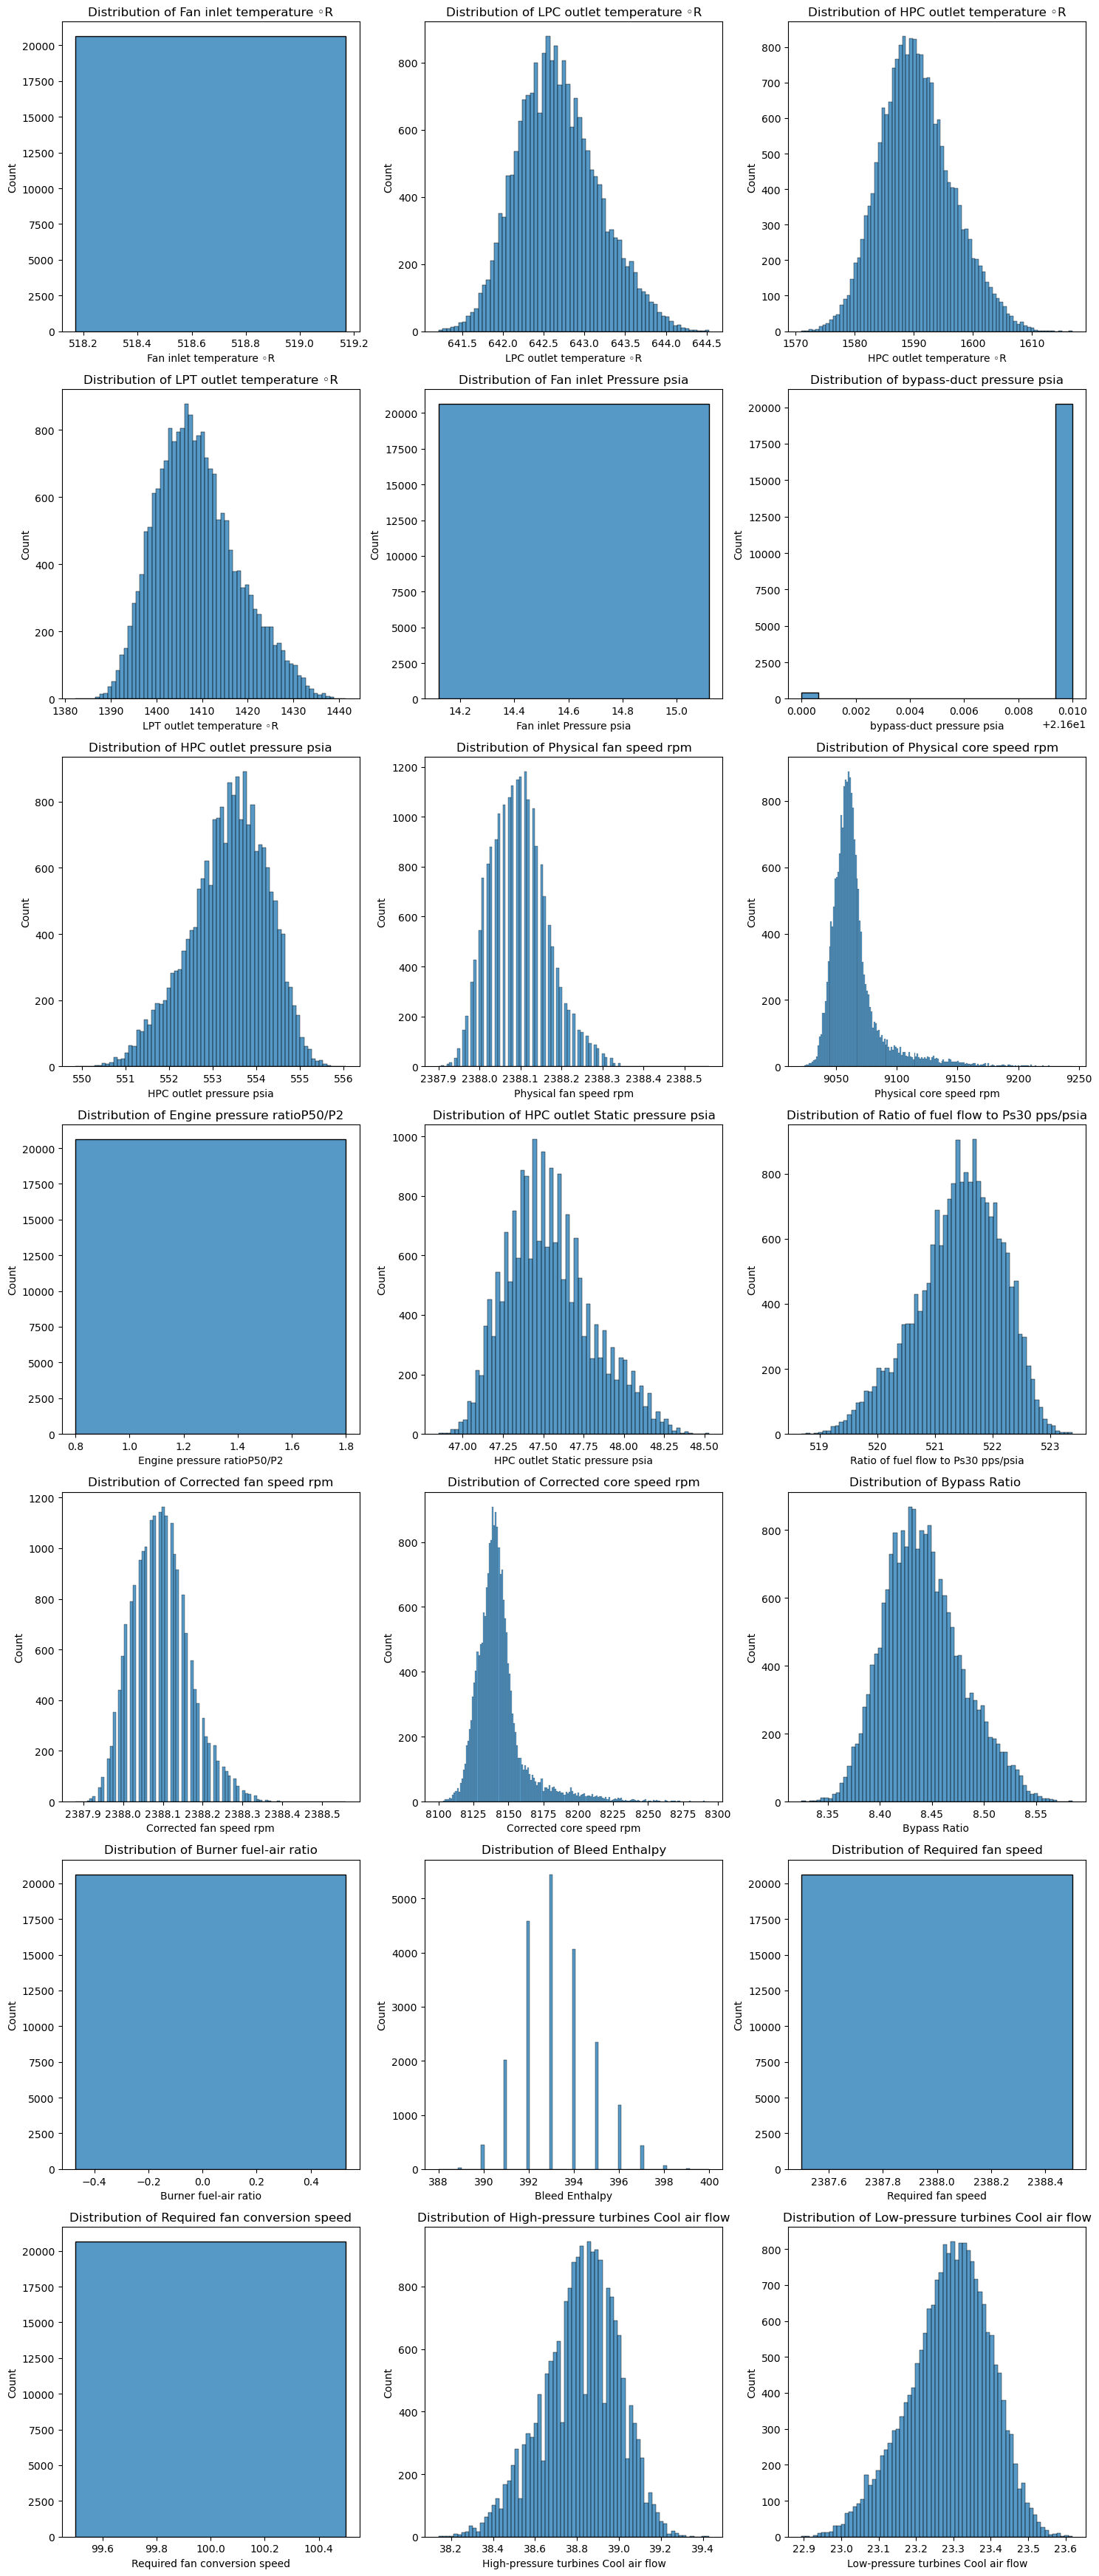

Columns that need normalization: ['bypass-duct pressure psia', 'Physical core speed rpm', 'Corrected core speed rpm']


In [298]:
columns_to_normalize = []

# Determine the number of rows and columns for the subplot grid
num_columns = len([col for col in FD001_data.columns if col in sensor_names])
num_rows = int(np.ceil(num_columns / 3)) #Making columns

# Create subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))  
axes = axes.flatten()  # Flatten to easily iterate over it

# Loop through each column and create an individual plot (only sensor names)
for i, column in enumerate(FD001_data[sensor_names]):
    if column in sensor_names:
        sns.histplot(data=FD001_data[column], ax=axes[i])
        axes[i].set_title(f'Distribution of {column}')
        skewness = FD001_data[column].skew()
        print(f'Skewness of {column}: {skewness}')
        
        # Check if the skewness is outside the range of -0.5 to 0.5
        if skewness < -0.5 or skewness > 0.5:
            columns_to_normalize.append(column)

# Hide any unused subplots if there are any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Print the columns that need normalization
print(f'Columns that need normalization: {columns_to_normalize}')


The Data is mostly gaussian and predictable. In the time series application, I was able to decompose all the sensor data and determine residuls, QQplot. The data can be found timeSeries_explore.ipynb. 

I decided not to normalize the 'Physical core speed rpm', and
'Corrected core speed rpm' due to the scores and residuals of the time series decompostion and prediction square difference. Also this data is modeled to reflect real-world scenarios and at this time I'm deciding to not normalize these two features even though there are indications of skewness. 

I will treat this excercise in terms that I'm familiar with. In computer scinece we have ways of evaluating the health of computer components and software. Each component of a system has health metrics that indicate stress, load, deterioration and so-on. Although I'm not a domain expert in jet engines I will try and assume that the coponents of a jet fan engine have the same indicators though some meaningful modles that we can use to understand the health of that component.

Modern jet engines generally operate at 40 to 55:1 at sea level.(Our test case).Generally speaking, higher overall pressure ratio implies higher efficiency. The disadvantage to higher efficiency is heat. As air travels through the compressor, it reaches temps that could cause the deterioration of the compressor blades. This is especially true for the last compressor stage(Wikipedia.org). 

The workflow for the jet fan engine is as follows:

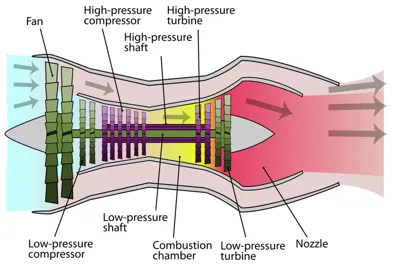






In [299]:
# Defining the HPC threshold failure margin
HPC_stall_margin_threshold = 0.144

# Normal operating conditions or baseline efficiency and flow values (#provide reference Juba)
eta_0 = 0.40  # baseline efficiency (n_0) when the engine was new
baseline_flow = +0.08  # baseline flow

# Constants for standard conditions(conditions at sea level)
T_std = 518.67  # Standard temperature in Rankine
P_std = 14.70  # Standard pressure in psia

# Stall Margin calculation Coefficients Derived from the table of Wear Values
a = -3.81 # Coefficient for efficiency loss
b = +2.57  # Coefficient for flow loss
c = 1.0    # Example intercept

#Gathering and setting data for calculations mentioned int he formula area. 
T_inlet = FD001_data['Fan inlet temperature ◦R']
P_inlet = FD001_data['Fan inlet Pressure psia']
T_outlet_actual = FD001_data['HPC outlet temperature ◦R']
P_outlet = FD001_data['HPC outlet pressure psia']
#used to calculate how much the temperature would rise due to compression process. 1.4 is standard for air under these conditions for turbine engines. 
gamma = 1.4 

# Pressure ratio across HPC
PR = P_outlet / P_inlet

# Calculate ideal outlet temperature for isentropic process
T_outlet_ideal = T_inlet * (PR ** ((gamma - 1) / gamma))

# Current efficiency calculation
eta = (T_outlet_ideal - T_inlet) / (T_outlet_actual - T_inlet)

# Efficiency Loss calculation
efficiency_loss = eta_0 - eta
FD001_data['efficiency_loss'] = efficiency_loss

# Corrected flow calculation
corrected_flow = np.sqrt(T_inlet / T_std) * (P_std / P_inlet)

# Flow Loss calculation
flow_loss = baseline_flow - corrected_flow
FD001_data['flow_loss'] = flow_loss

# Stall Margin calculation
stall_margin = a * efficiency_loss + b * flow_loss + c
FD001_data['stall_margin'] = stall_margin

# Define the nominal stall margin for comparison
nominal_stall_margin = FD001_data['stall_margin'].max()  # Assuming max stall_margin as the nominal value

# Calculate the threshold for failure
stall_margin_failure_threshold = nominal_stall_margin * (1 - HPC_stall_margin_threshold)

# Check if stall margin falls below the threshold and flag it
FD001_data['HPC_failure'] = FD001_data['stall_margin'] < stall_margin_failure_threshold

# Display the rows where the failure condition is met
failures = FD001_data[FD001_data['HPC_failure']]


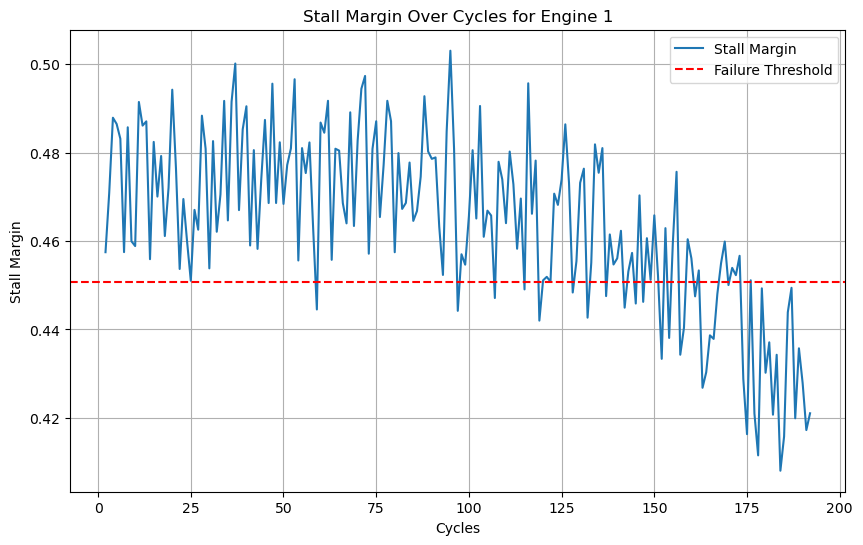

In [300]:
engine_id = 1
engine_data = FD001_data[FD001_data['Engine'] == engine_id]

plt.figure(figsize=(10, 6))
plt.plot(engine_data['Cycles'], engine_data['stall_margin'], label='Stall Margin')
plt.axhline(stall_margin_failure_threshold, color='red', linestyle='--', label='Failure Threshold')
plt.title(f'Stall Margin Over Cycles for Engine {engine_id}')
plt.xlabel('Cycles')
plt.ylabel('Stall Margin')
plt.legend()
plt.grid(True)
plt.show()

#print(stall_margin)




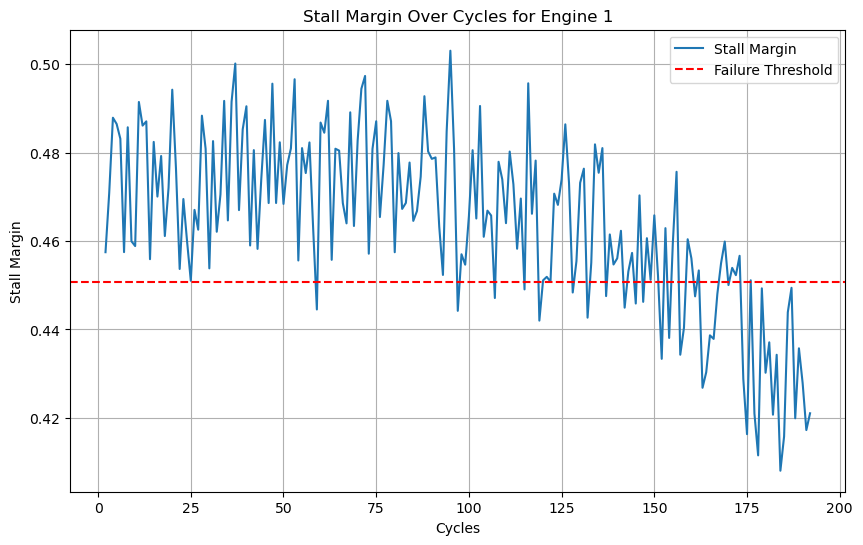

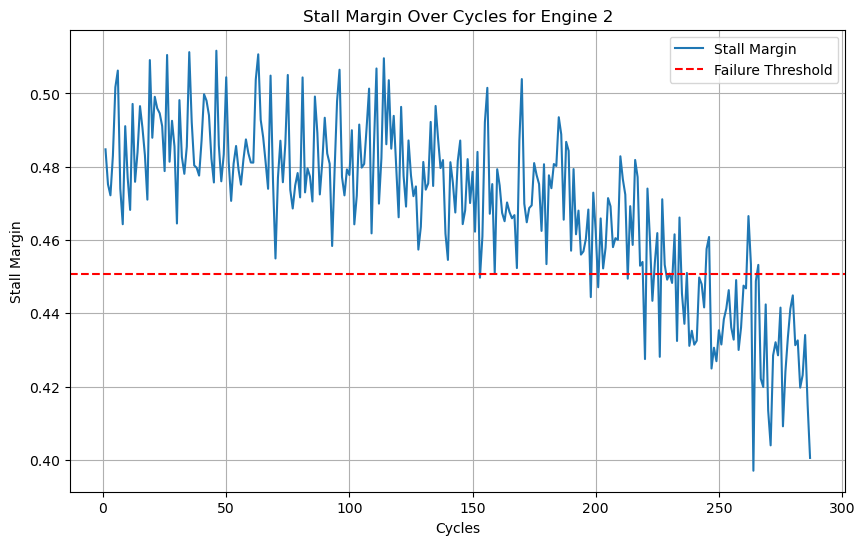

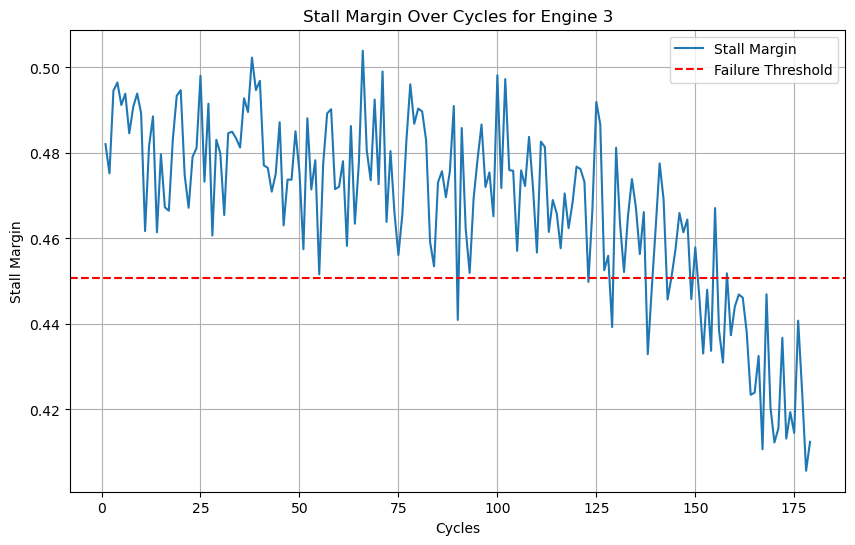

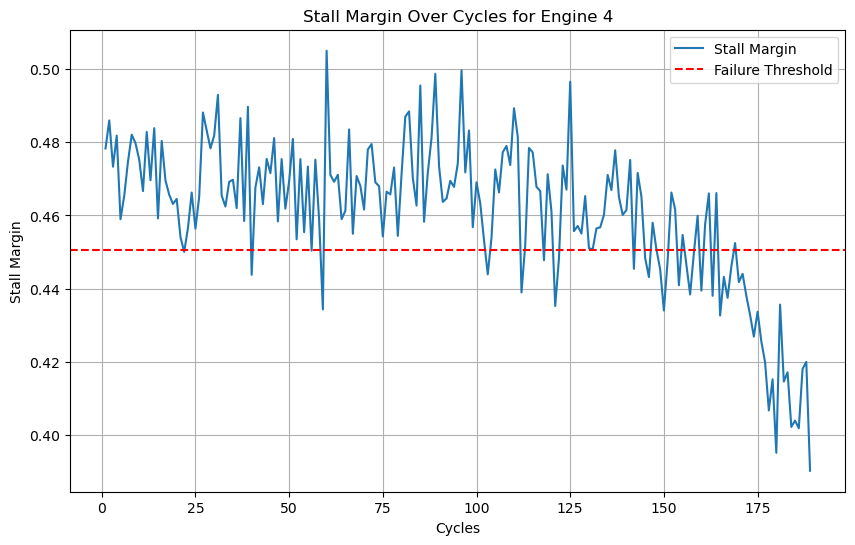

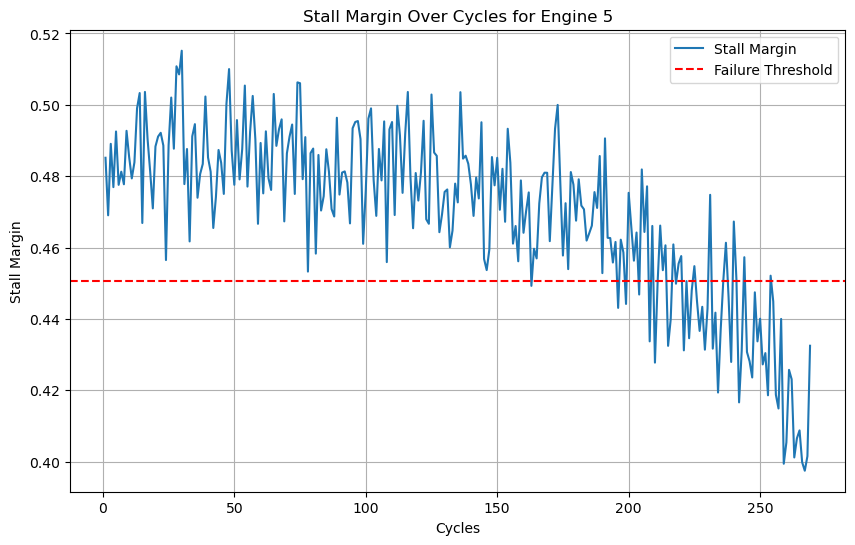

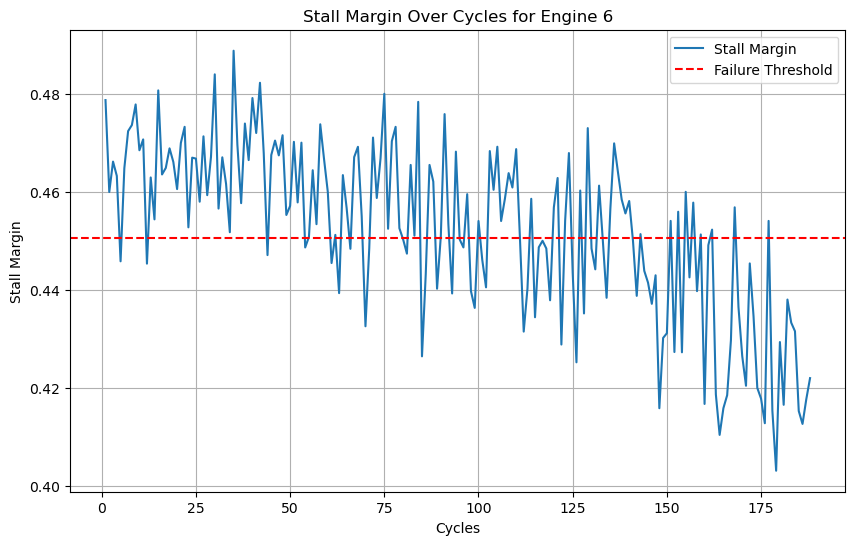

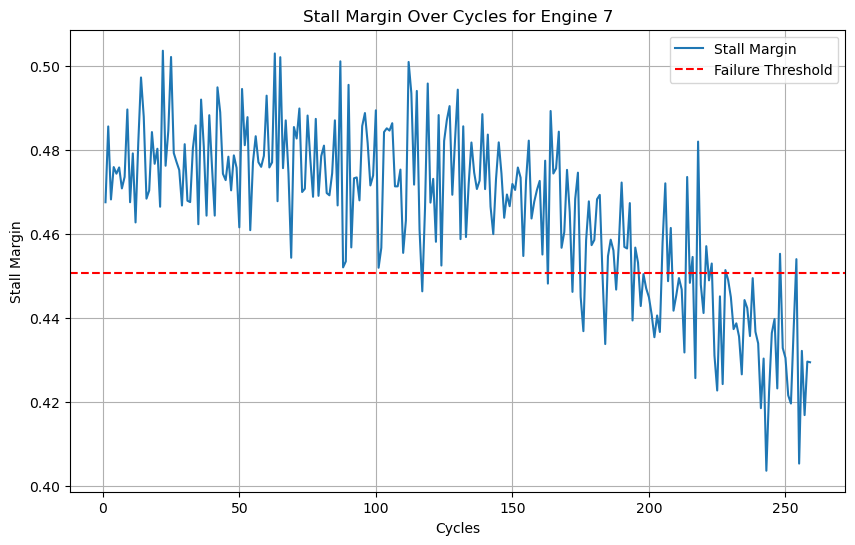

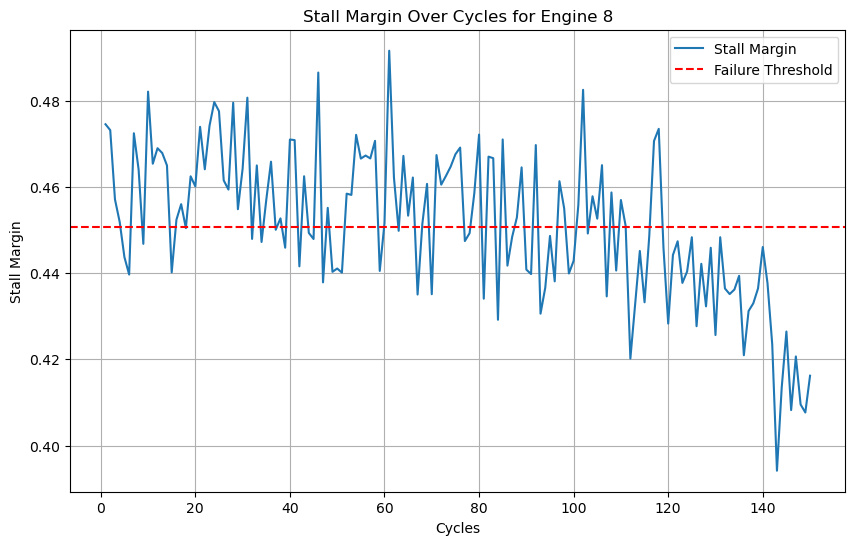

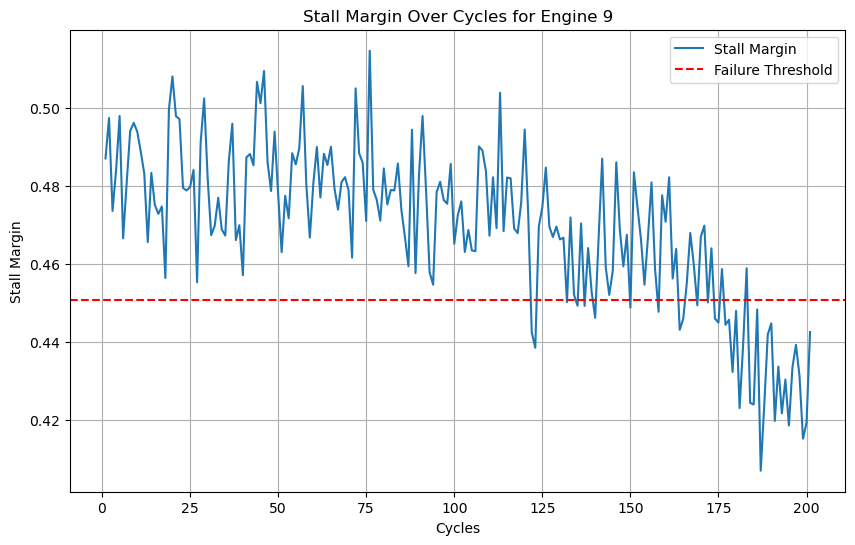

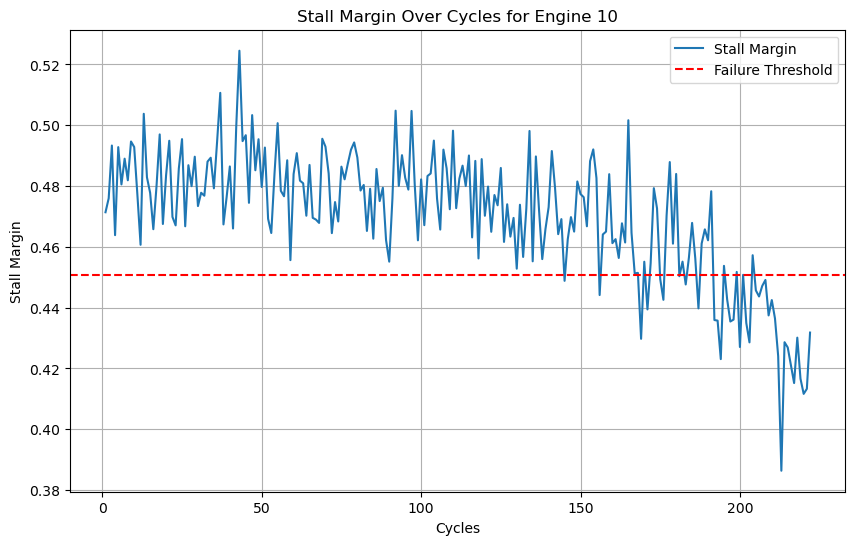

In [301]:
import matplotlib.pyplot as plt

# Function to plot stall margin over cycles for each engine
def plot_stall_margin(engine_ids, df, failure_threshold):
    for engine_id in engine_ids:
        engine_data = df[df['Engine'] == engine_id]

        plt.figure(figsize=(10, 6))
        plt.plot(engine_data['Cycles'], engine_data['stall_margin'], label='Stall Margin')
        plt.axhline(failure_threshold, color='red', linestyle='--', label='Failure Threshold')
        plt.title(f'Stall Margin Over Cycles for Engine {engine_id}')
        plt.xlabel('Cycles')
        plt.ylabel('Stall Margin')
        plt.legend()
        plt.grid(True)
        plt.show()

# Assuming 'Engine' column identifies the engine number and 'Cycles' column identifies the cycle count
engine_ids = FD001_data['Engine'].unique()[:10]  # Select the first 10 engines

# Plot stall margin for the first 10 engines
plot_stall_margin(engine_ids, FD001_data, stall_margin_failure_threshold)


In [302]:
FD001_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20630 entries, 0 to 20629
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Engine                                20630 non-null  int64  
 1   Cycles                                20630 non-null  int64  
 2   Operational Setting 1                 20630 non-null  float64
 3   Operational Setting 2                 20630 non-null  float64
 4   Operational Setting 3                 20630 non-null  float64
 5   Fan inlet temperature ◦R              20630 non-null  float64
 6   LPC outlet temperature ◦R             20630 non-null  float64
 7   HPC outlet temperature ◦R             20630 non-null  float64
 8   LPT outlet temperature ◦R             20630 non-null  float64
 9   Fan inlet Pressure psia               20630 non-null  float64
 10  bypass-duct pressure psia             20630 non-null  float64
 11  HPC outlet pres

In [303]:
#adding wear manifest ranges as features

#Initial Wear
FD001_data['Baseline_Efficiency'] =0.0
FD001_data['Initial_Wear_HPT_Efficiency'] = -0.48
FD001_data['Initial_Wear_HPT_Flow'] = +0.08

#Wear 3000 Cycles
FD001_data['3000_Wear_HPT_Efficiency'] = -2.63
FD001_data['3000_Wear_HPT_Flow'] = +1.76

#Wear 6000 Cycles
FD001_data['6000_Wear_HPT_Efficiency'] = -3.81
FD001_data['6000_Wear_HPT_Flow'] = +2.57




In [304]:
X = FD001_data[['Cycles','Baseline_Efficiency','Initial_Wear_HPT_Efficiency','Initial_Wear_HPT_Flow','3000_Wear_HPT_Efficiency','3000_Wear_HPT_Flow','6000_Wear_HPT_Efficiency','6000_Wear_HPT_Flow']]
y = FD001_data['stall_margin']

scale = StandardScaler()
X_scale = scale.fit_transform(X)

In [305]:
lin_model = LinearRegression().fit(X_scale,y)
preds = lin_model.predict(X_scale)
absMean = mean_absolute_error(y,preds)
print(absMean)

0.013761562323998248


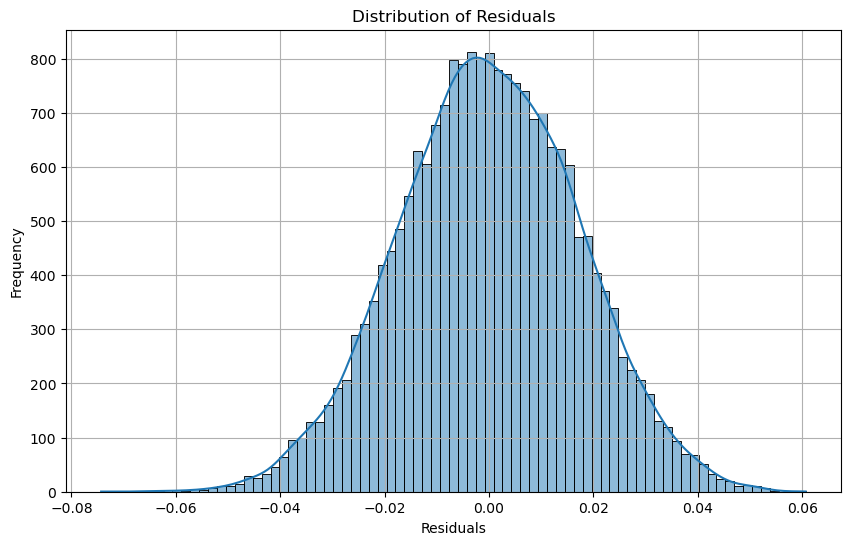

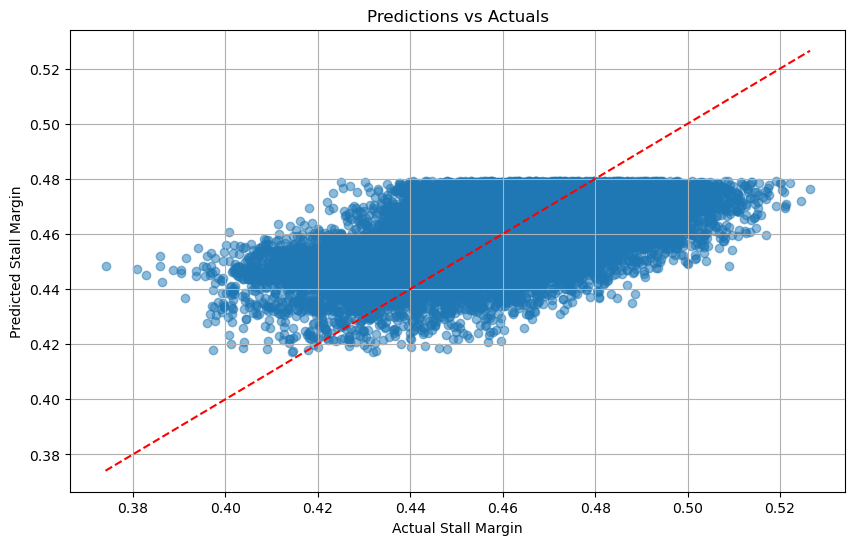

In [306]:
residuals = y - preds

# Plotting Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plotting Predictions vs. Actuals
plt.figure(figsize=(10, 6))
plt.scatter(y, preds, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red')  # Identity line
plt.title('Predictions vs Actuals')
plt.xlabel('Actual Stall Margin')
plt.ylabel('Predicted Stall Margin')
plt.grid(True)
plt.show()

In [307]:
poly_pipe = Pipeline([('poly',PolynomialFeatures()),('lin',LinearRegression())]).fit(X_scale,y)


In [308]:
params ={
    'poly__degree':[2,3],
    'lin__fit_intercept': [True, False]
}

In [309]:
poly_grid = GridSearchCV(poly_pipe,param_grid=params,n_jobs=-1,cv=5).fit(X_scale,y)
best_params = poly_grid.best_params_
best_score = poly_grid.best_score_

In [310]:
print(best_params,best_score)

{'lin__fit_intercept': False, 'poly__degree': 3} 0.3184821782853298


Mean Absolute Error (Polynomial): 0.013622234793790869


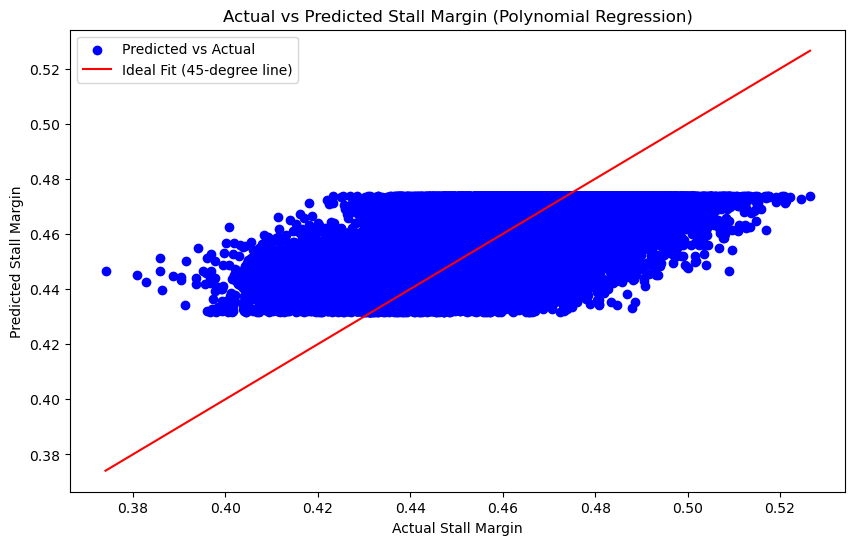

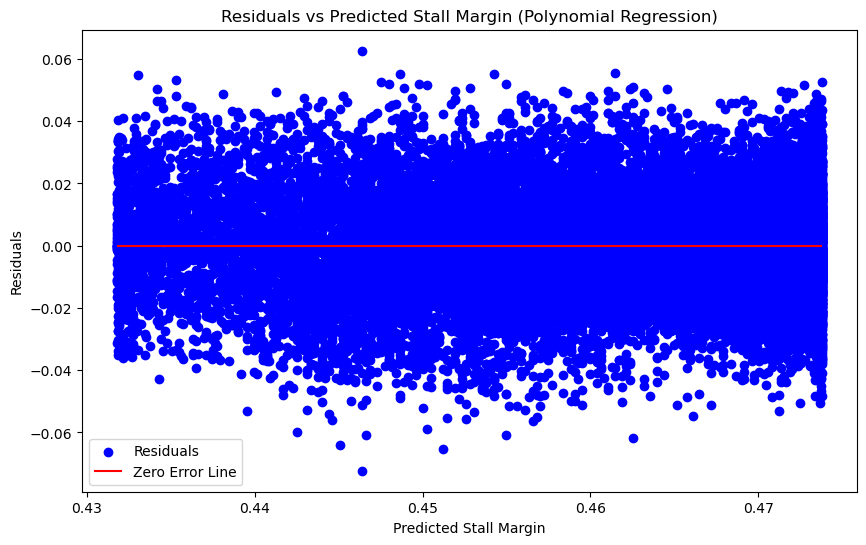

In [311]:
X = FD001_data[['Cycles','Baseline_Efficiency','Initial_Wear_HPT_Efficiency','Initial_Wear_HPT_Flow','3000_Wear_HPT_Efficiency','3000_Wear_HPT_Flow','6000_Wear_HPT_Efficiency','6000_Wear_HPT_Flow']]
y = FD001_data['stall_margin']

# Create polynomial features
poly = PolynomialFeatures(degree=3,include_bias=False)
X_poly = poly.fit_transform(X)

# Fit the polynomial regression model
poly_model = LinearRegression().fit(X_poly, y)

# Predict the stall margin using the model
y_poly_pred = poly_model.predict(X_poly)

# Calculate the mean absolute error
mae_poly = mean_absolute_error(y, y_poly_pred)
print(f'Mean Absolute Error (Polynomial): {mae_poly}')

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(y, y_poly_pred, color='blue', label='Predicted vs Actual')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', label='Ideal Fit (45-degree line)')
plt.xlabel('Actual Stall Margin')
plt.ylabel('Predicted Stall Margin')
plt.title('Actual vs Predicted Stall Margin (Polynomial Regression)')
plt.legend()
plt.show()

# Residuals plot
residuals = y - y_poly_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_poly_pred, residuals, color='blue', label='Residuals')
plt.hlines(y=0, xmin=min(y_poly_pred), xmax=max(y_poly_pred), color='red', label='Zero Error Line')
plt.xlabel('Predicted Stall Margin')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Stall Margin (Polynomial Regression)')
plt.legend()
plt.show()

My model isn't capturing all the variation in the data very well. The contributing factor could be that I'm modeling across the entire fleet instead of a single engine or not aggregating at all. 

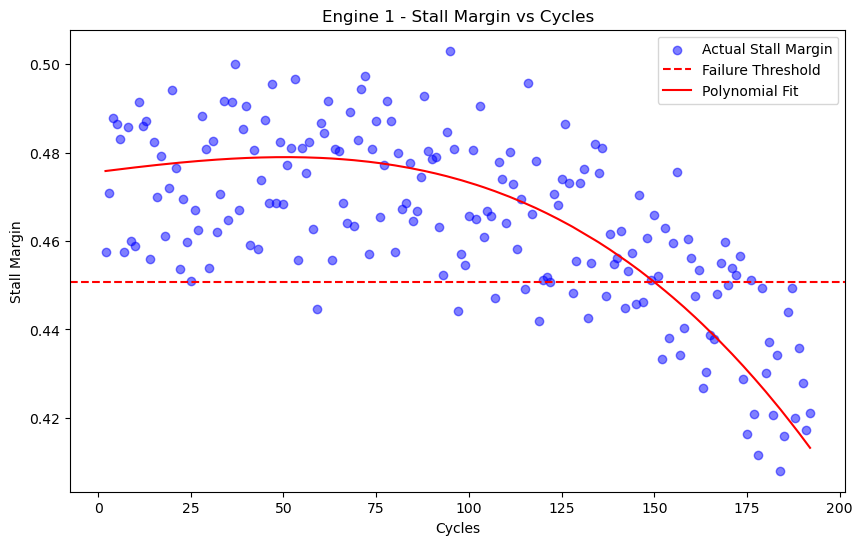

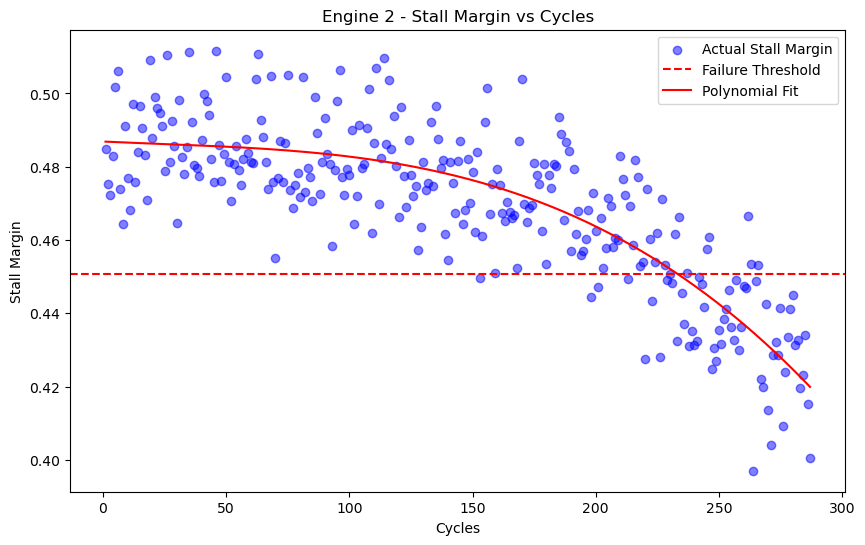

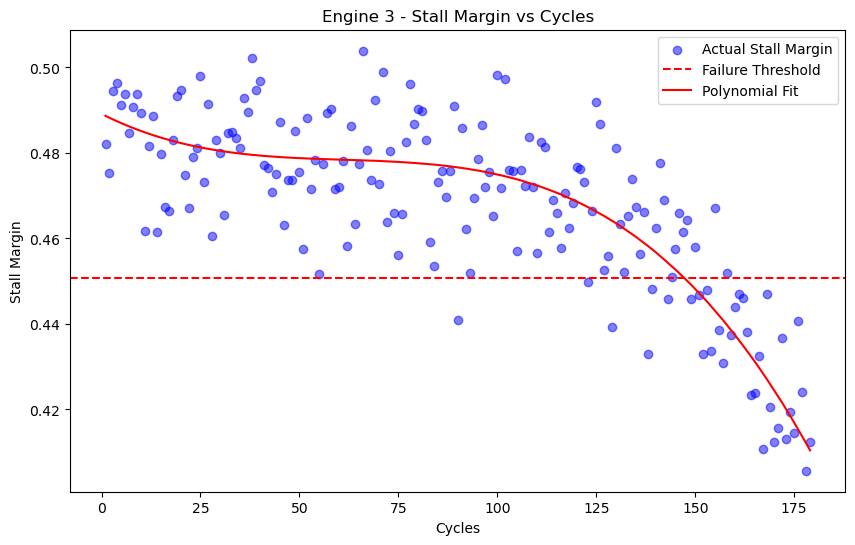

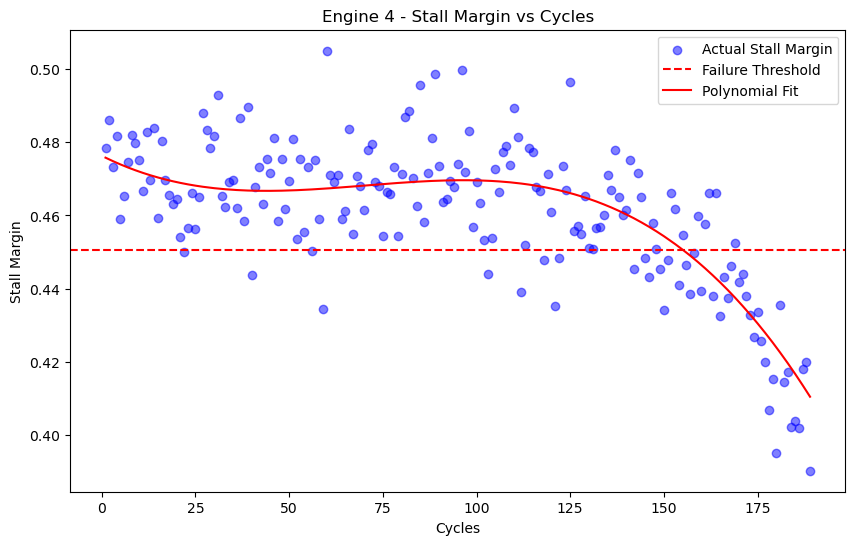

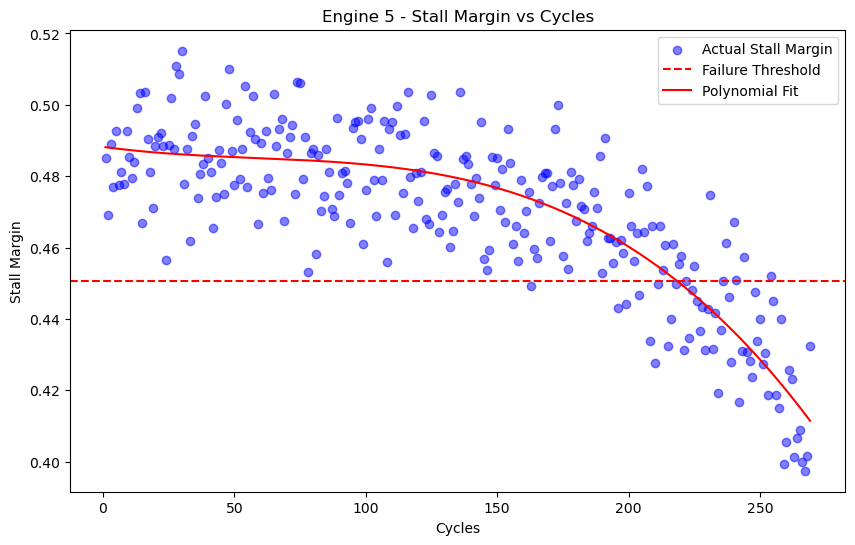

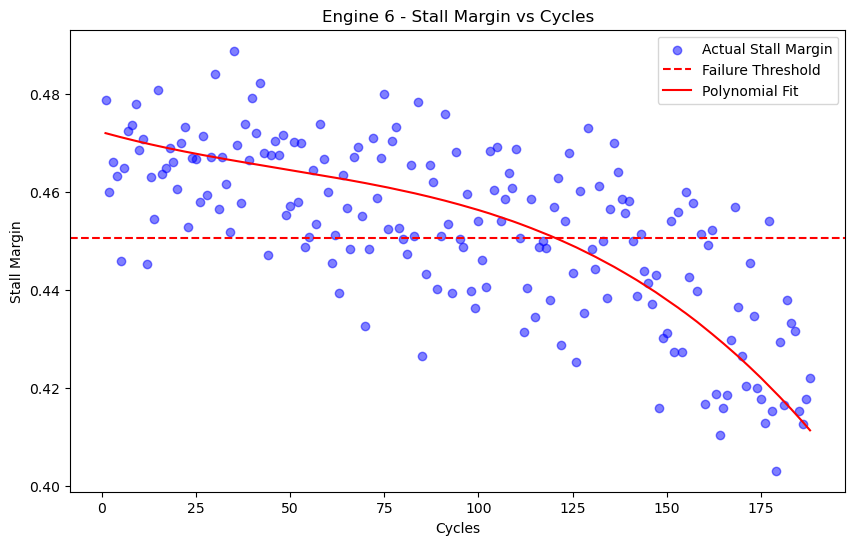

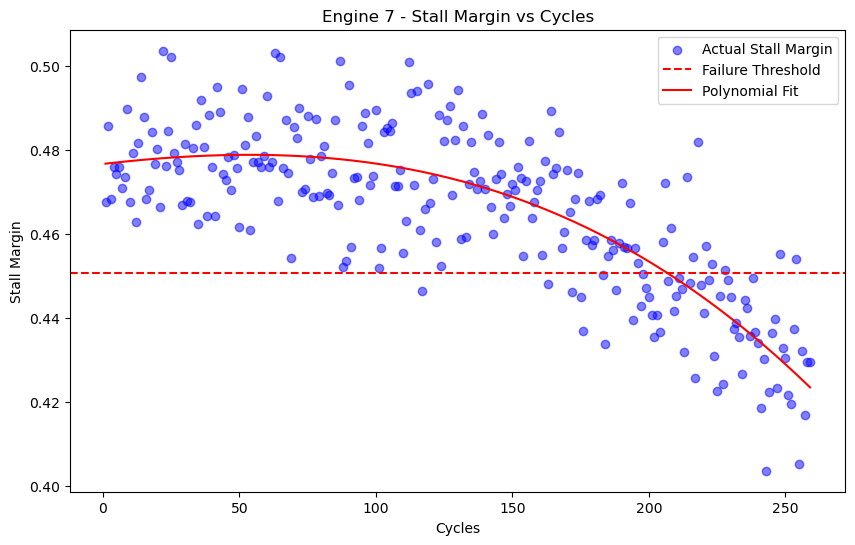

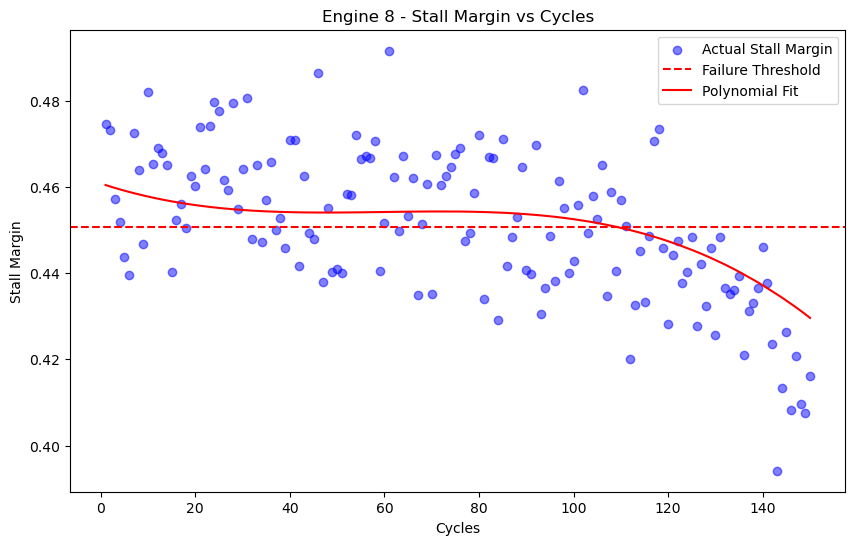

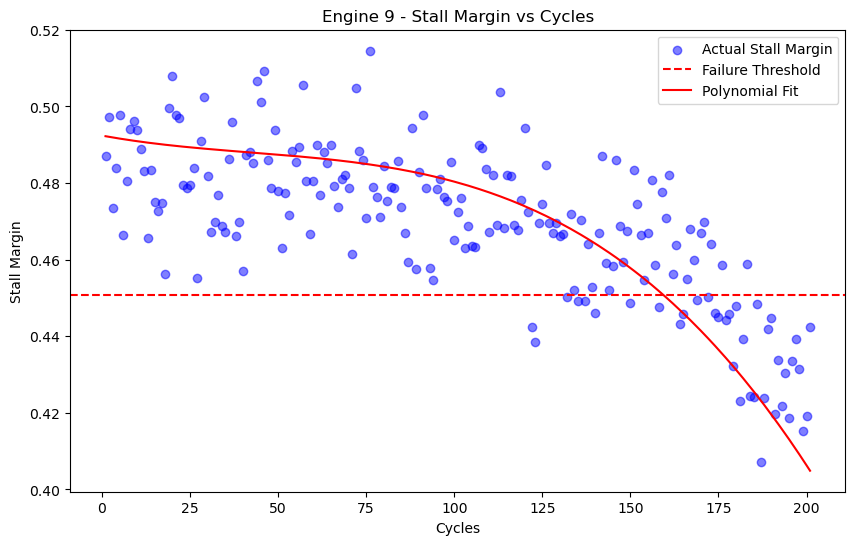

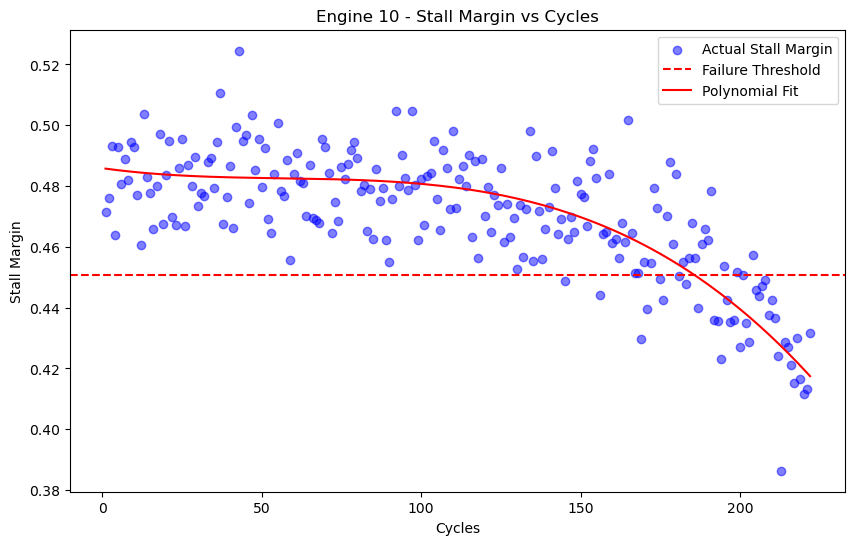

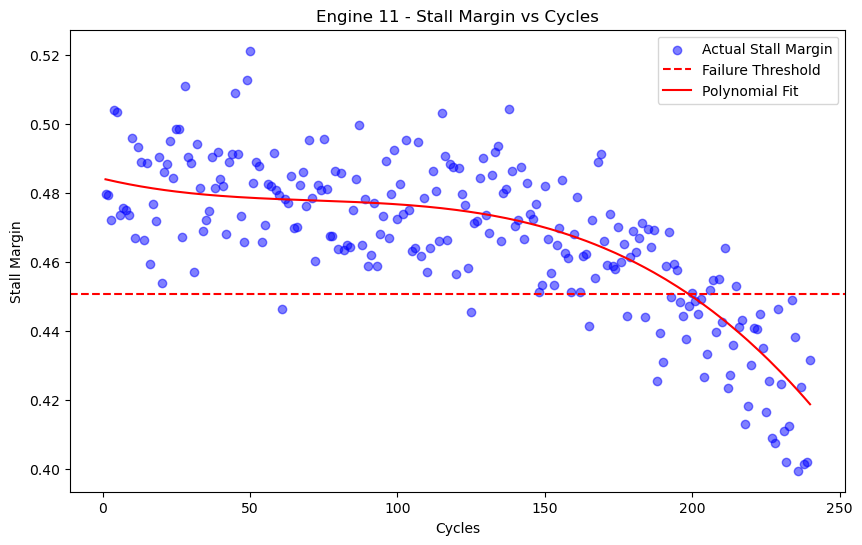

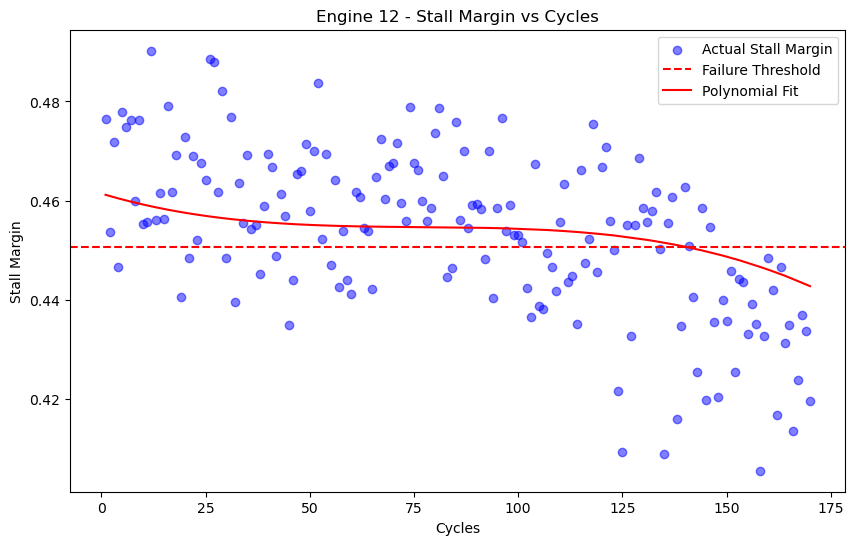

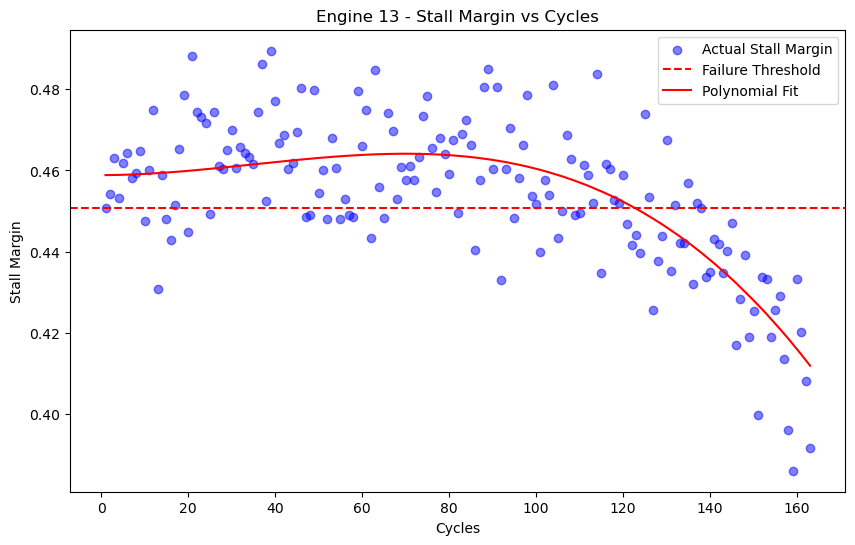

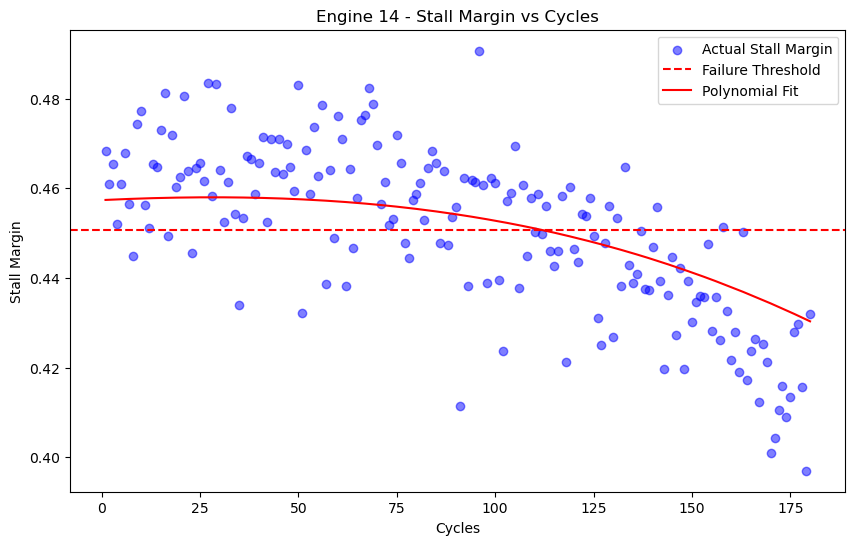

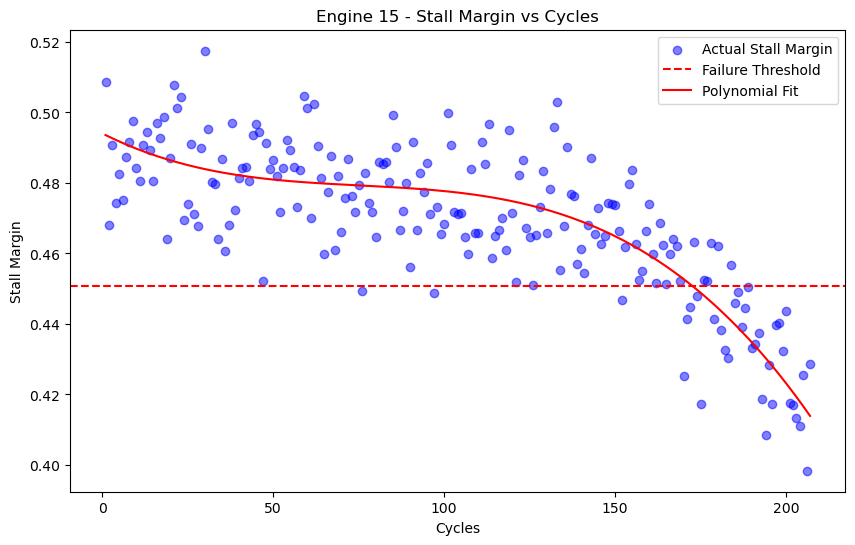

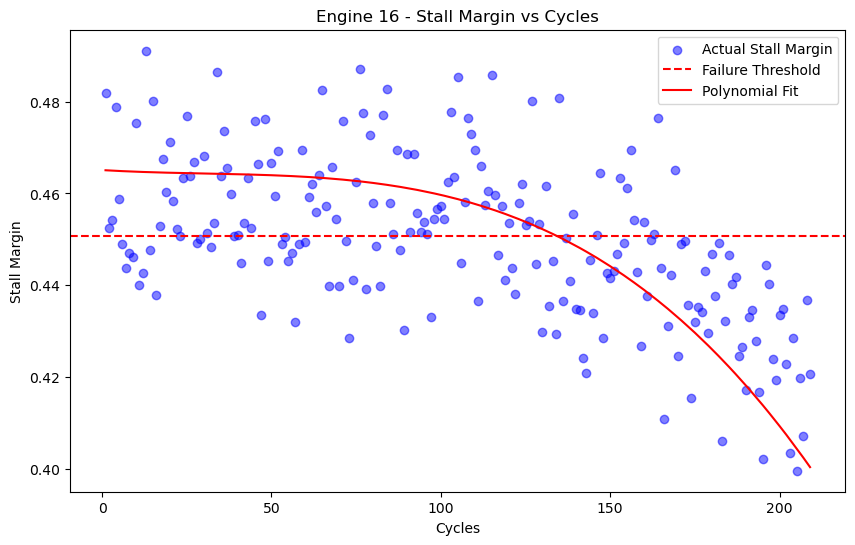

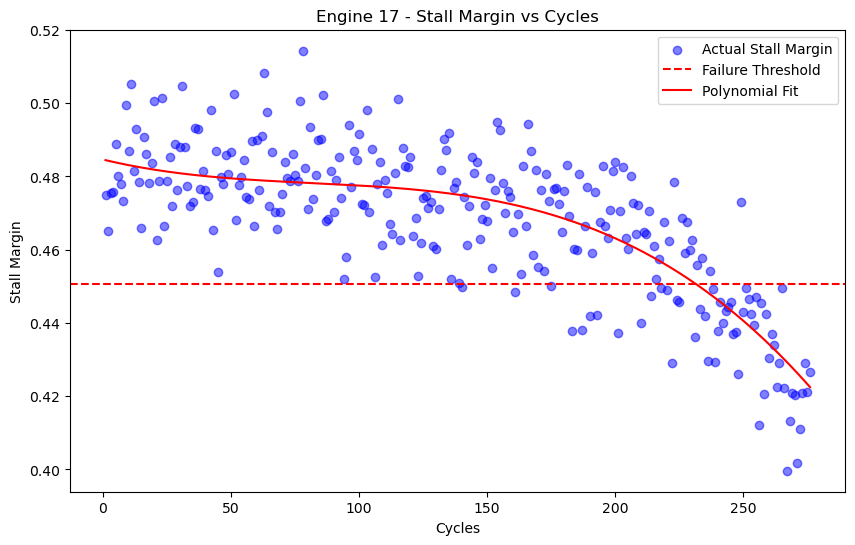

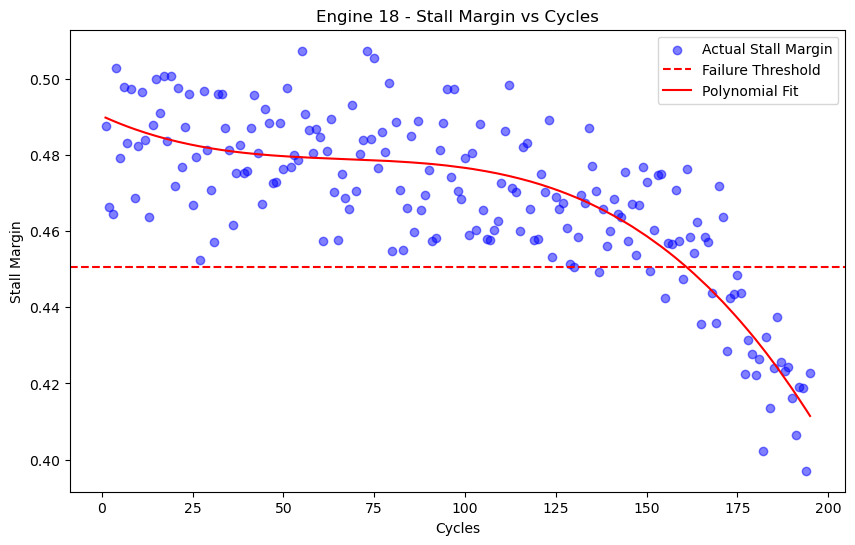

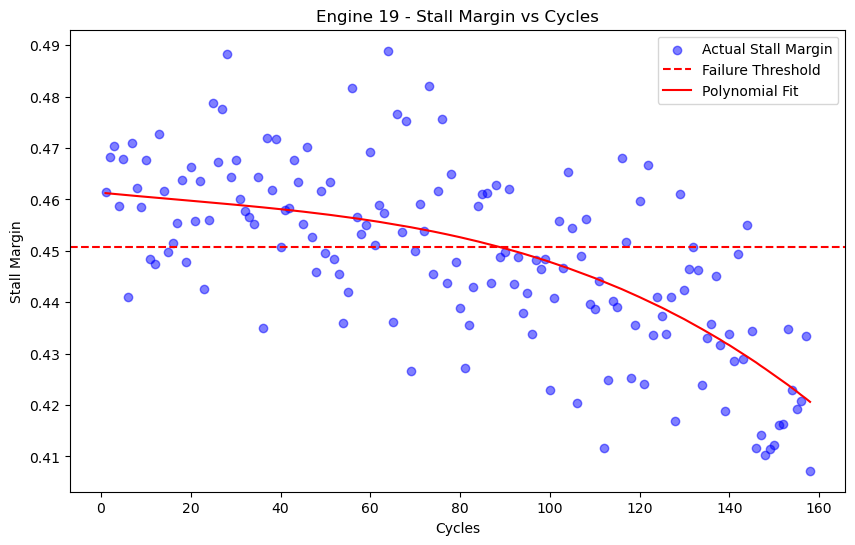

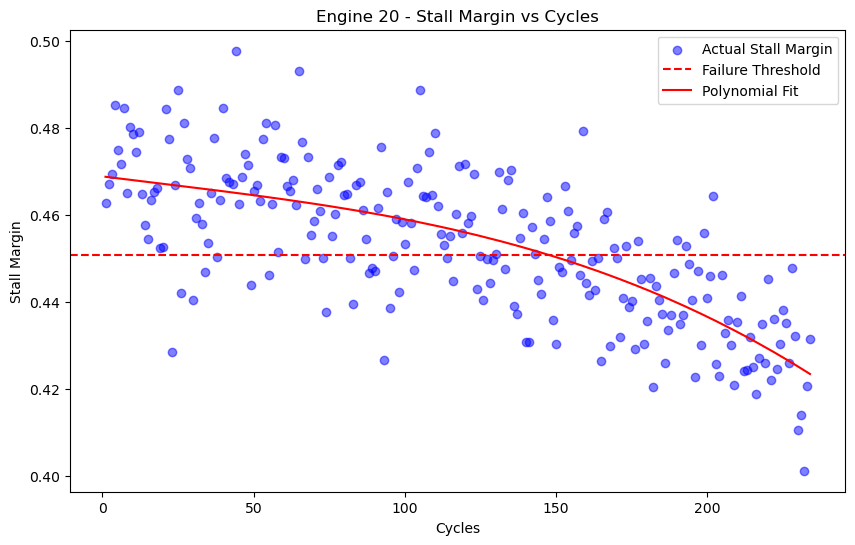

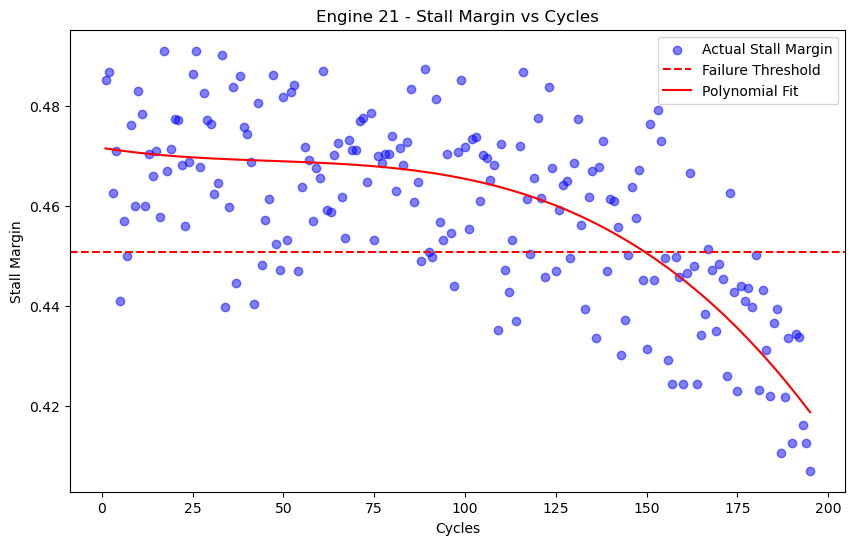

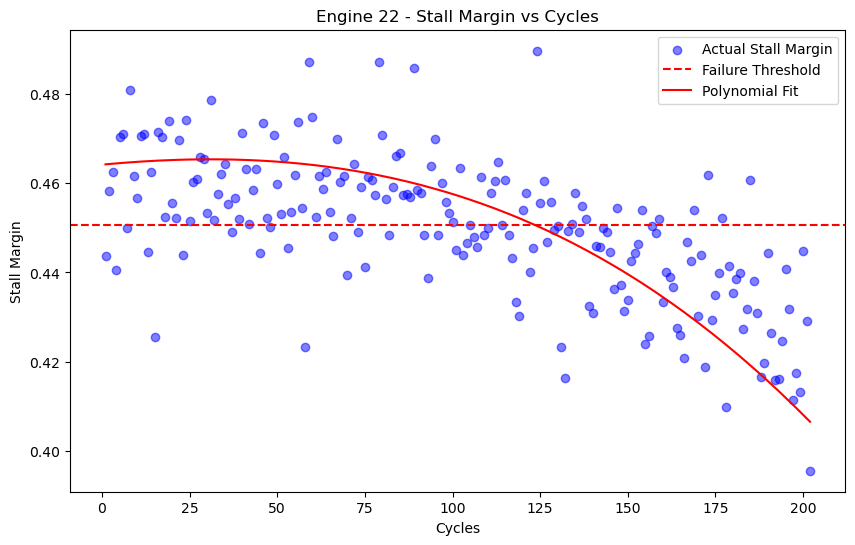

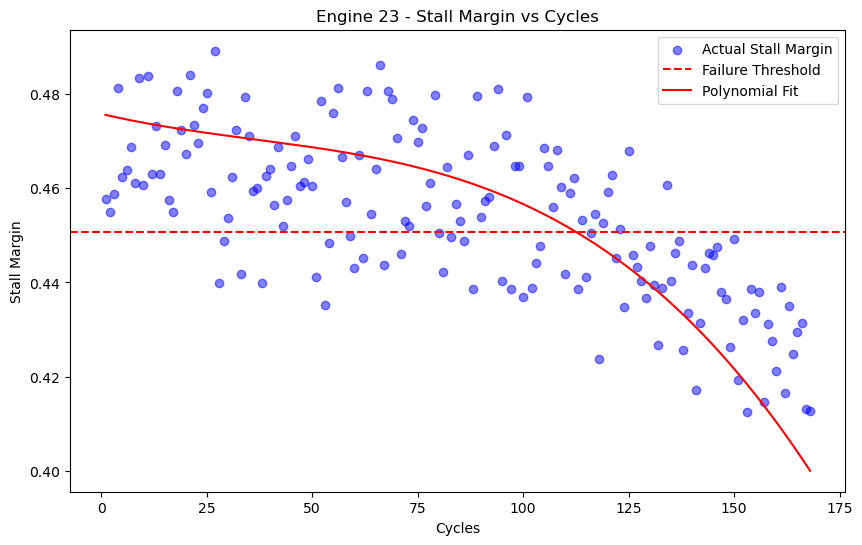

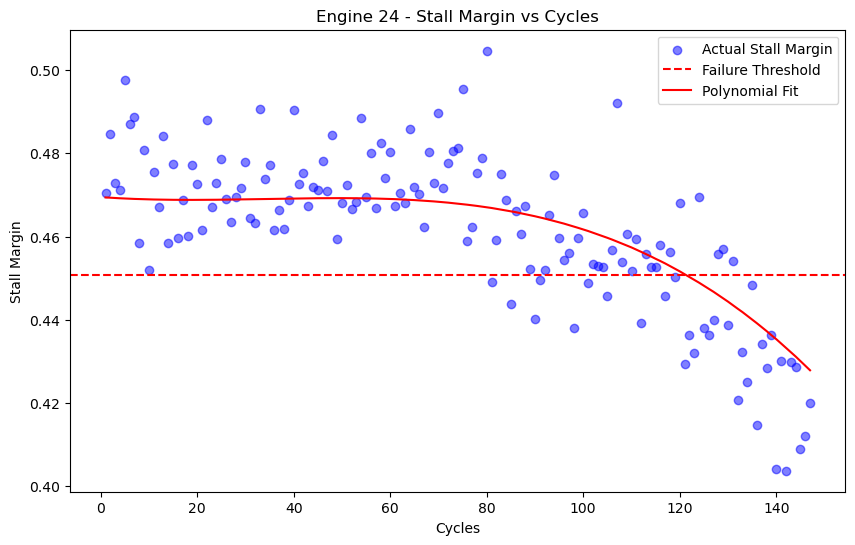

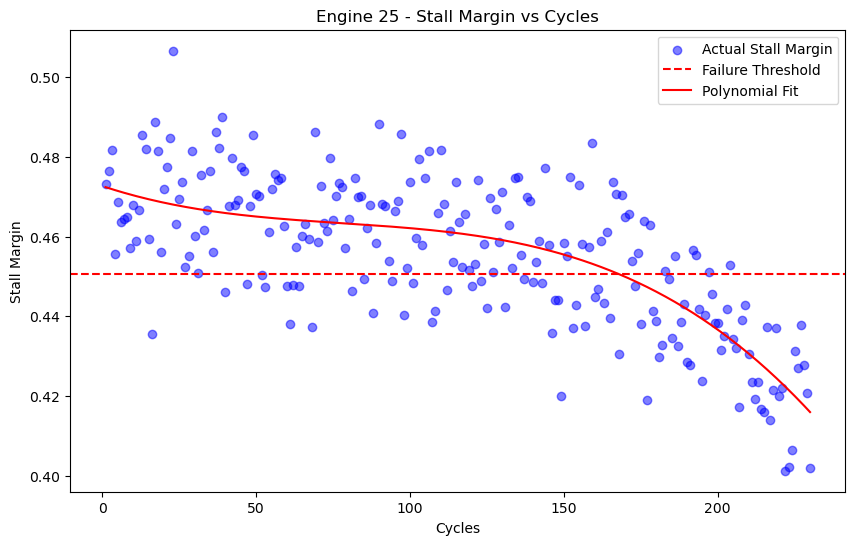

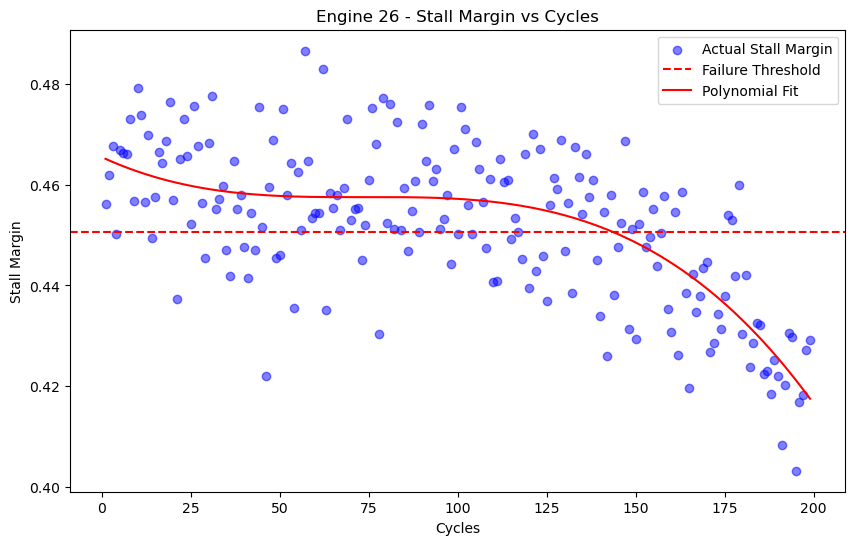

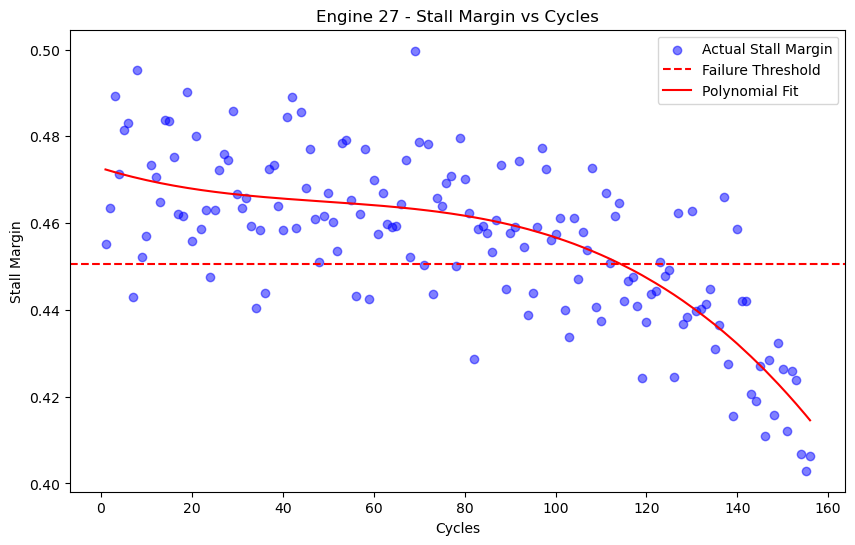

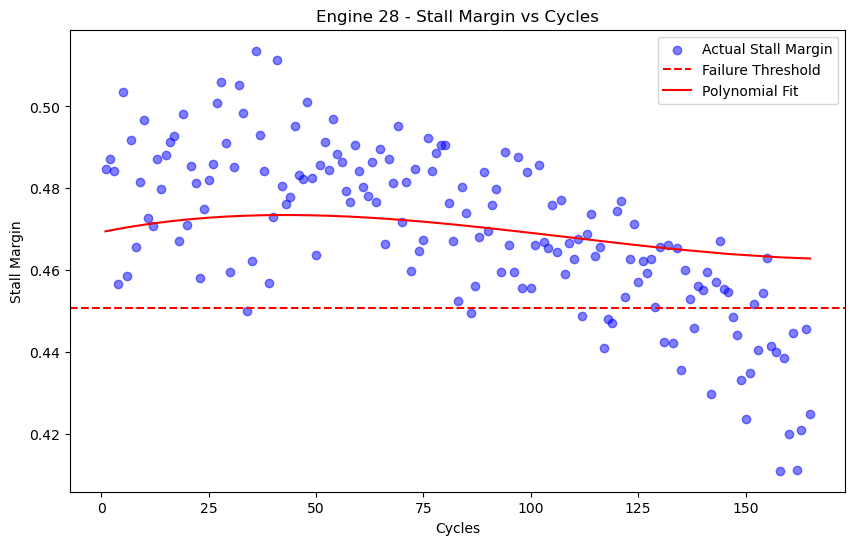

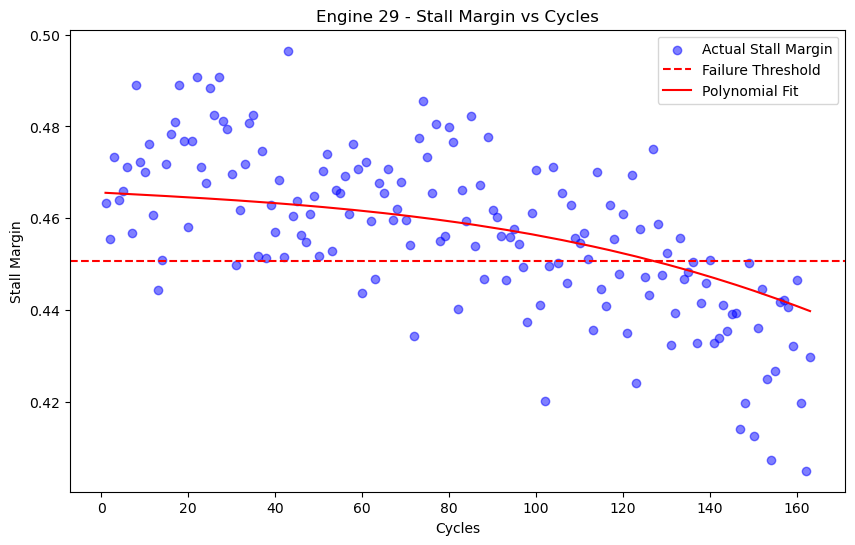

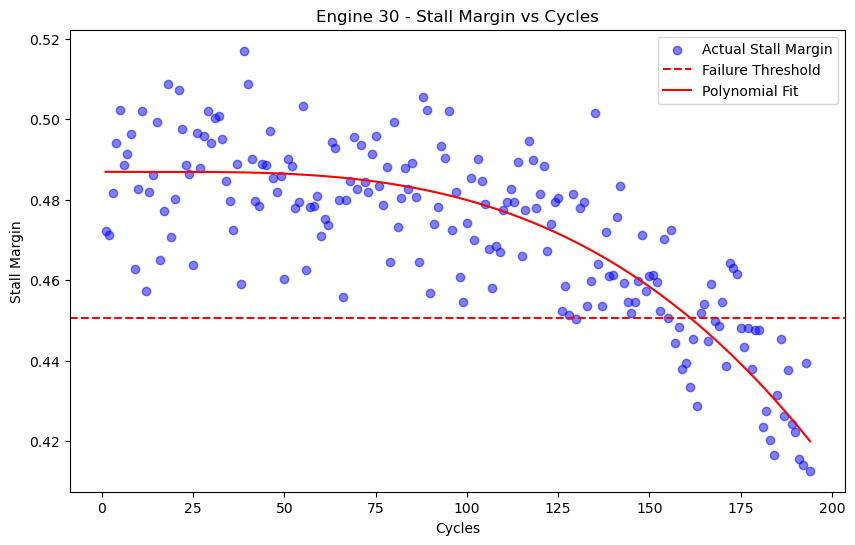

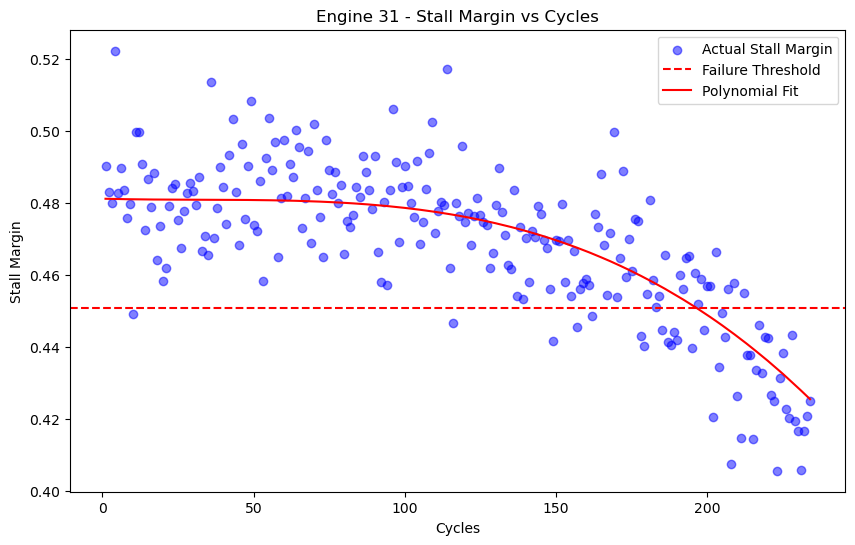

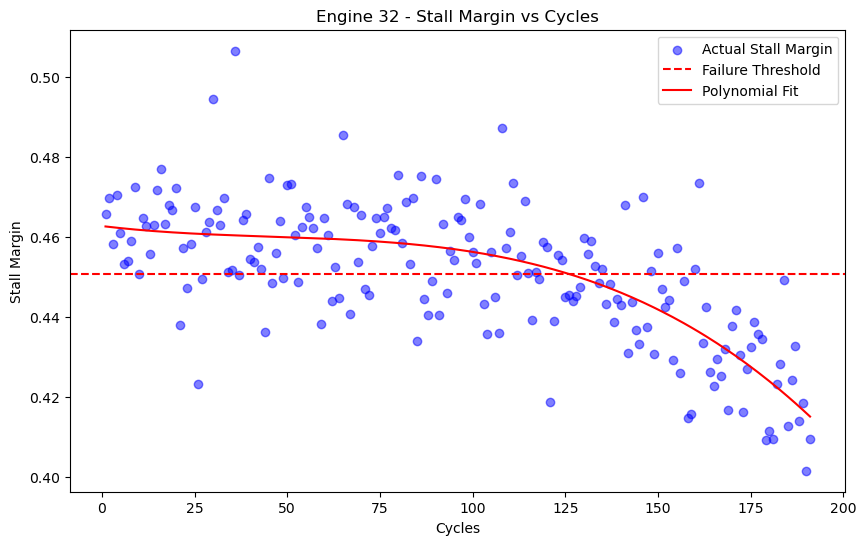

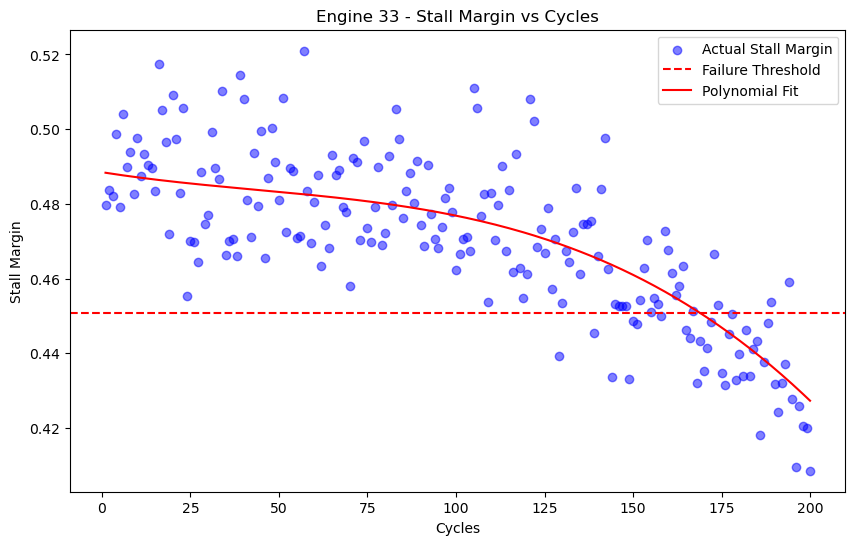

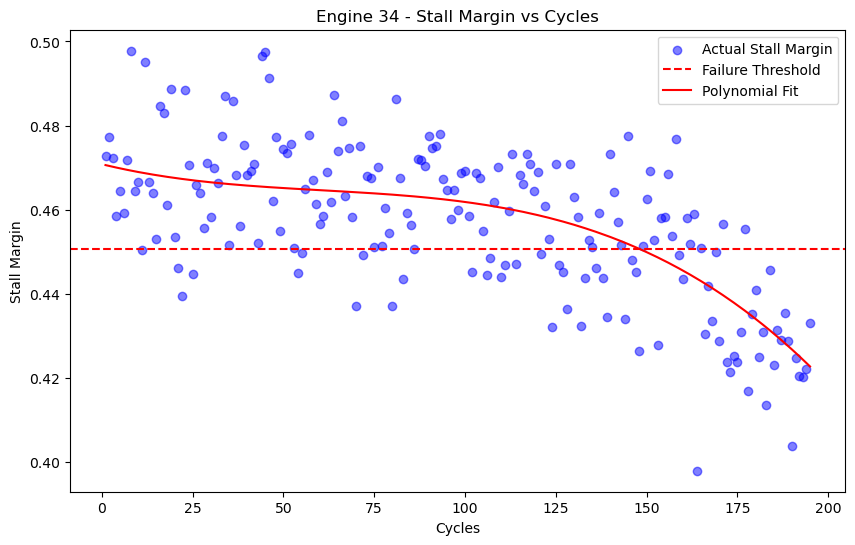

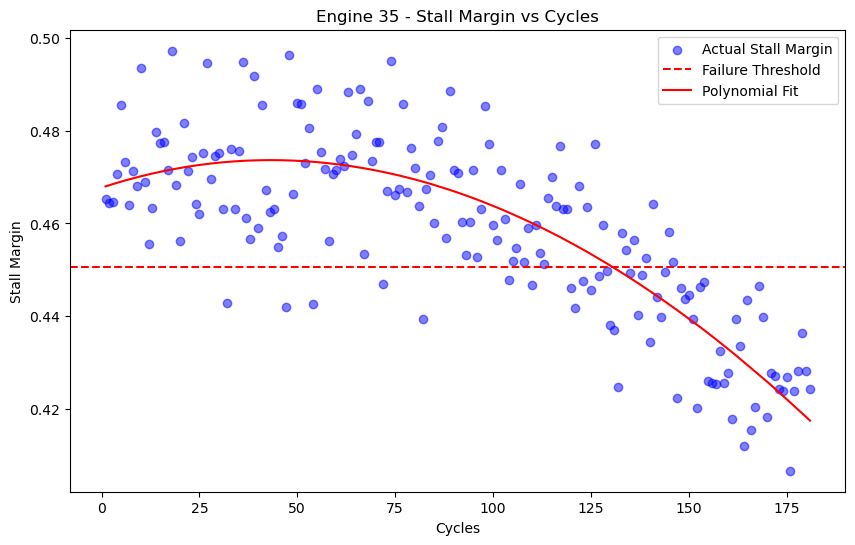

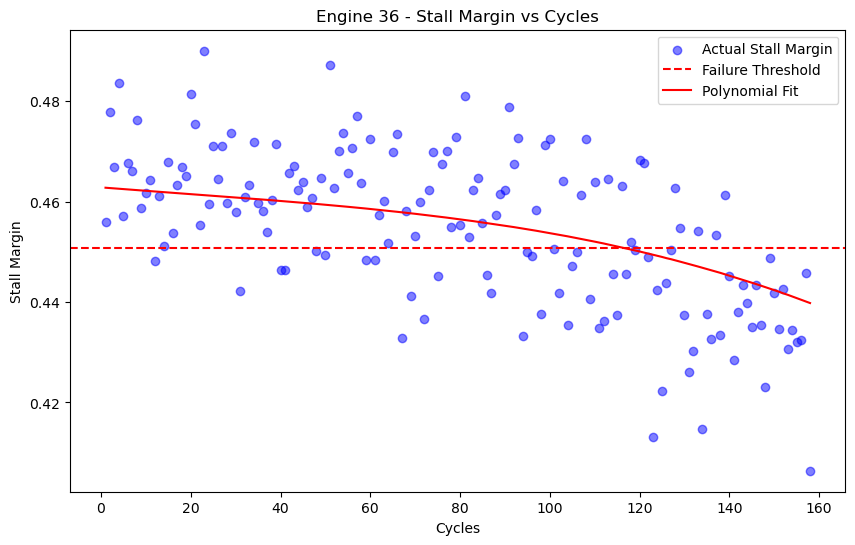

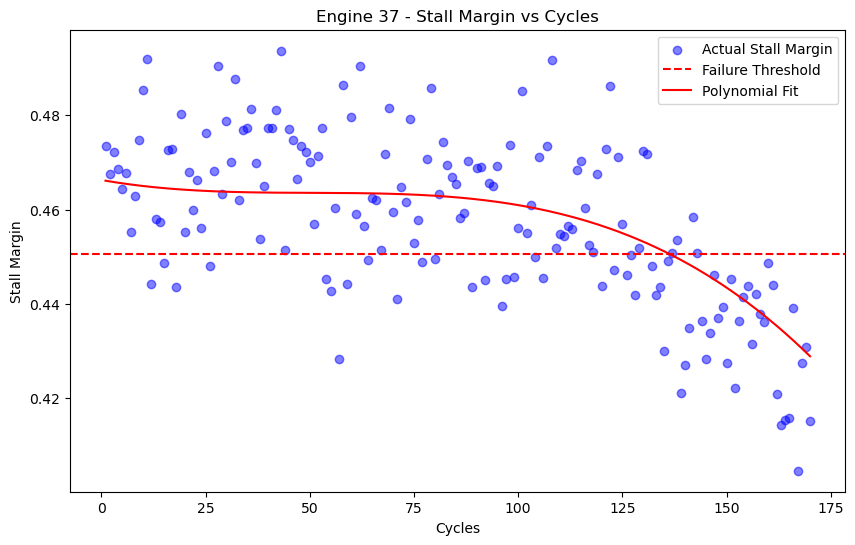

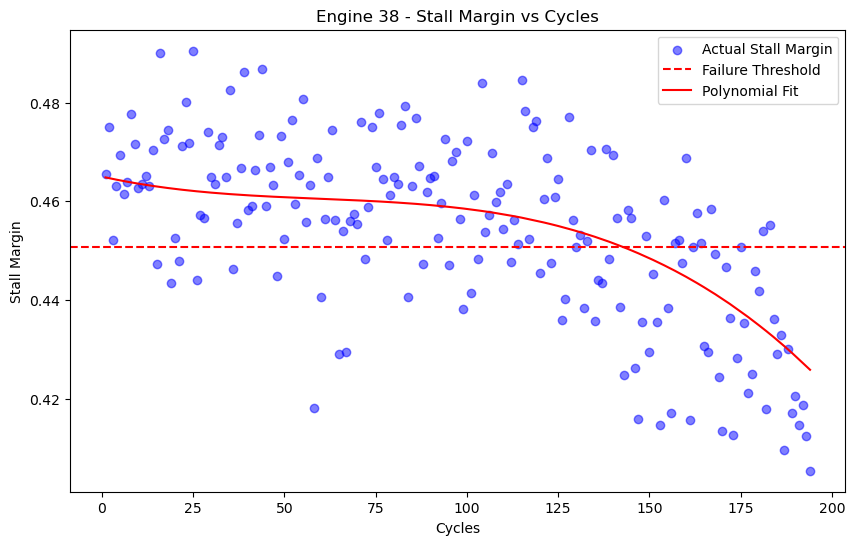

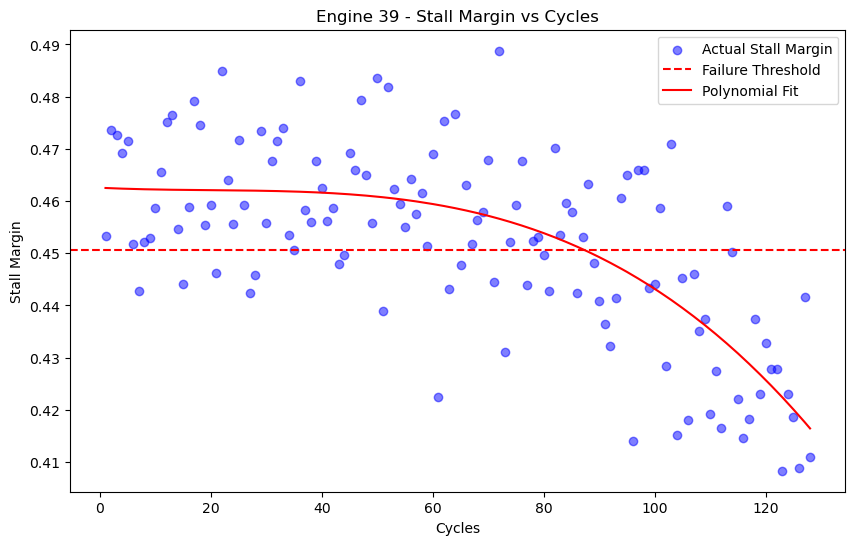

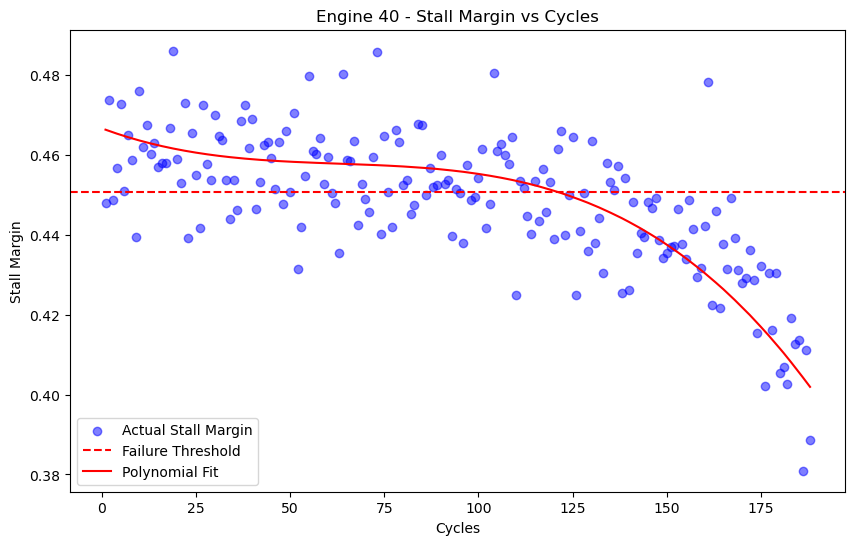

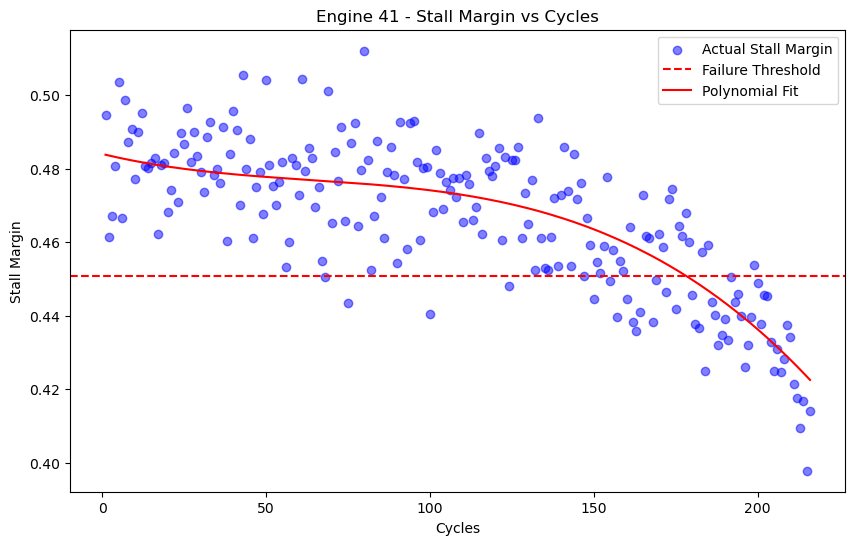

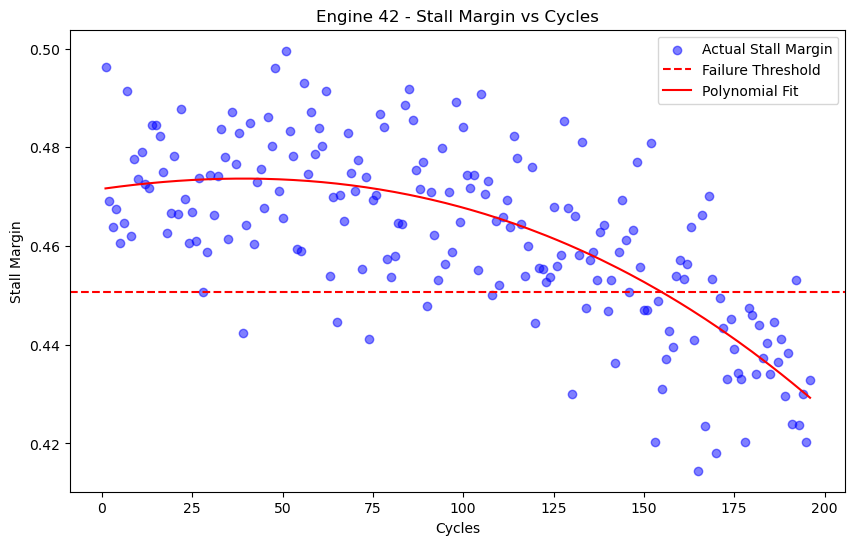

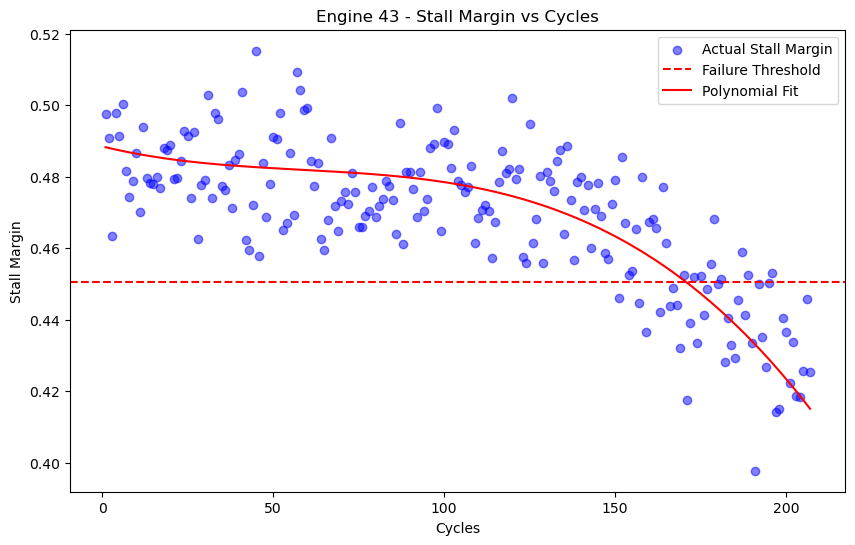

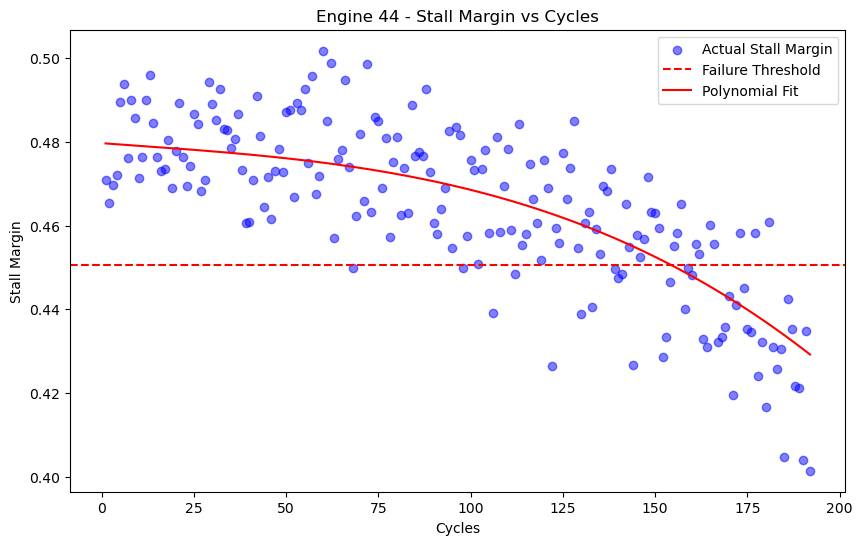

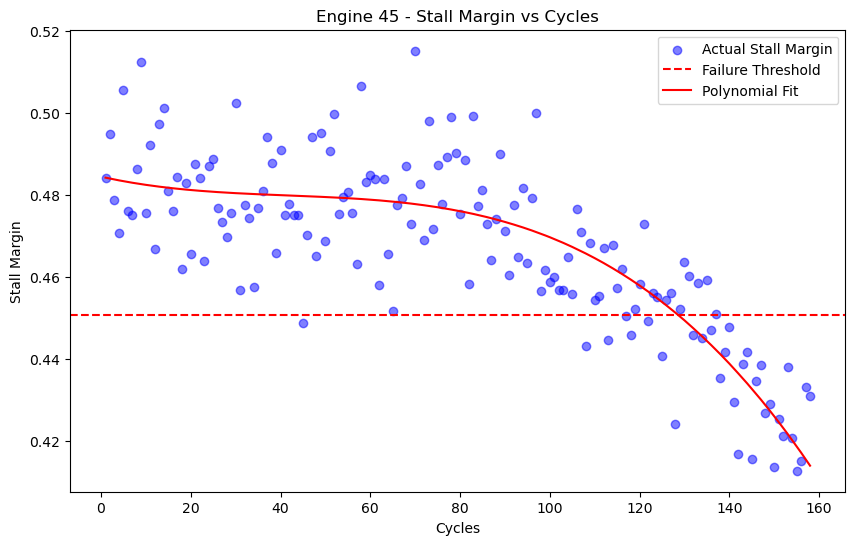

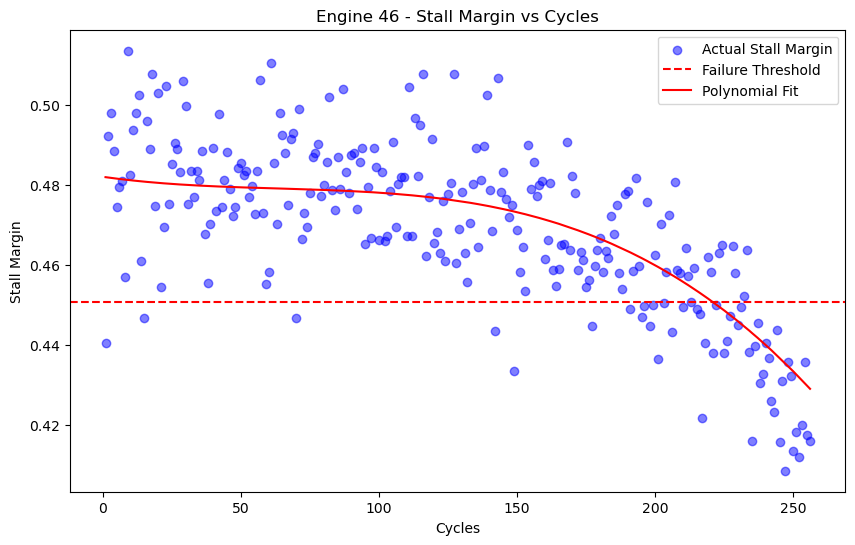

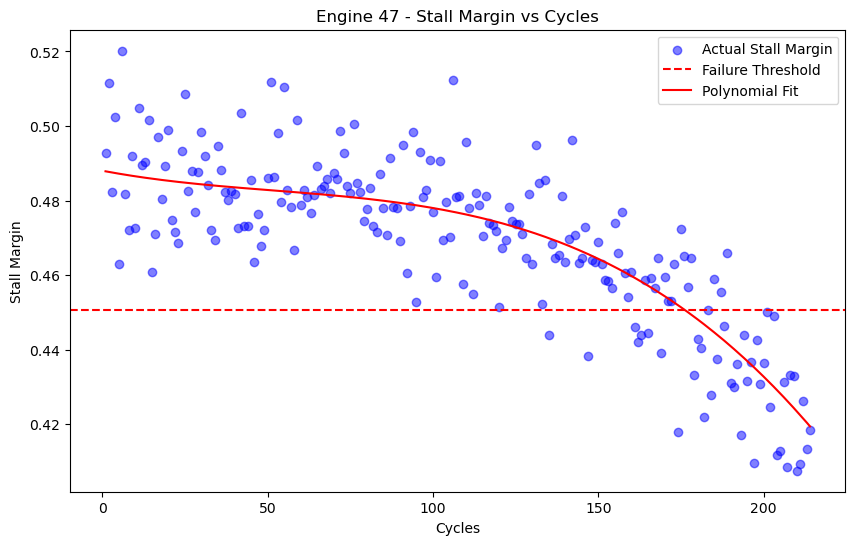

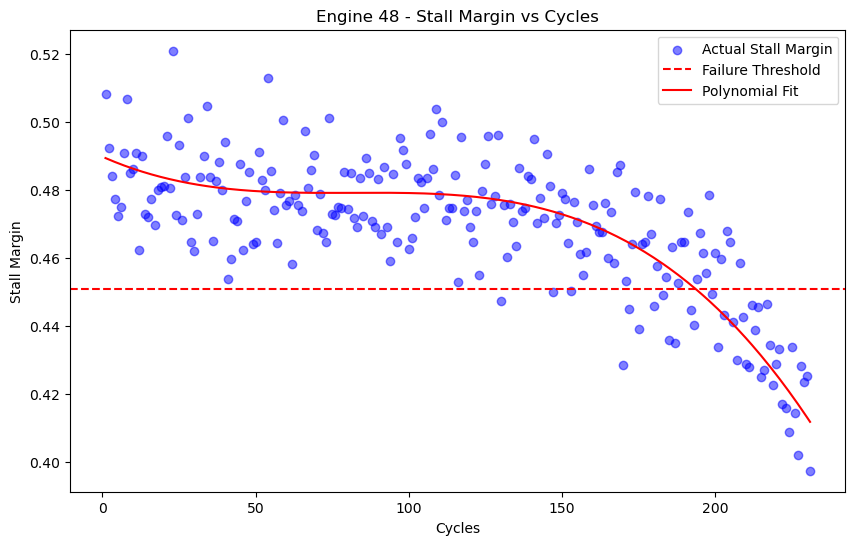

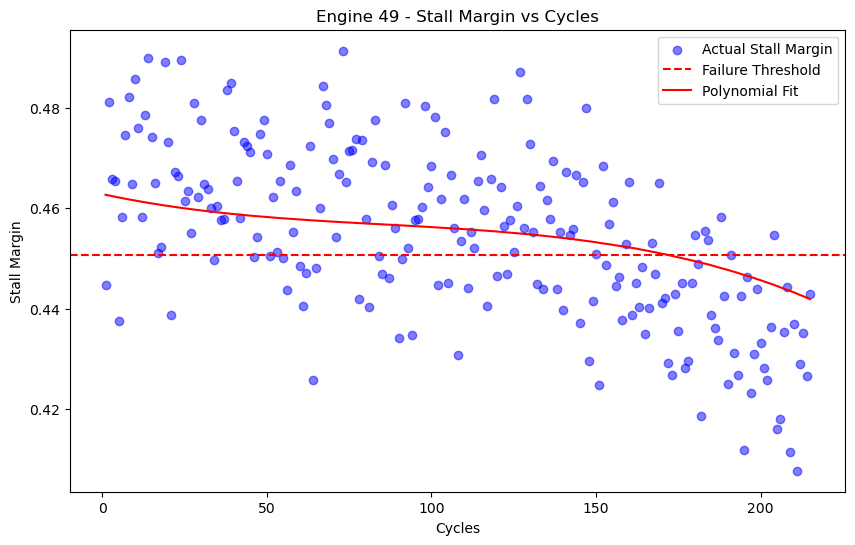

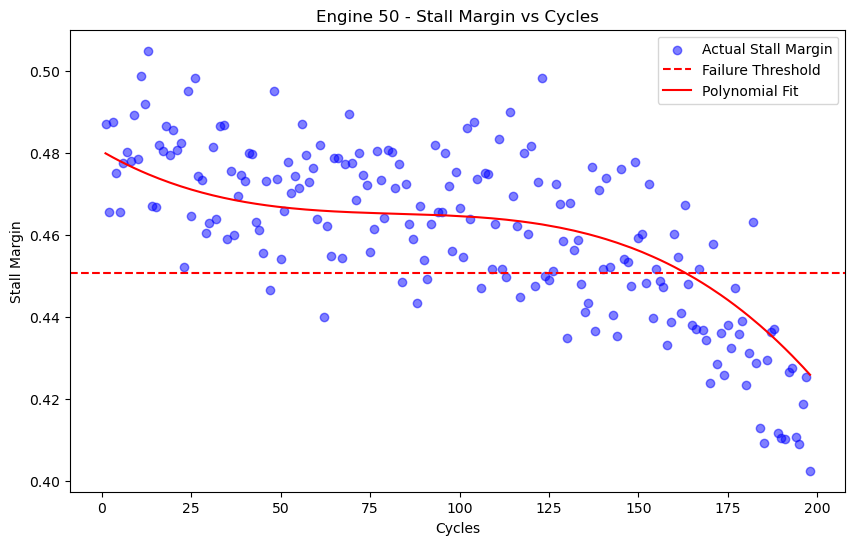

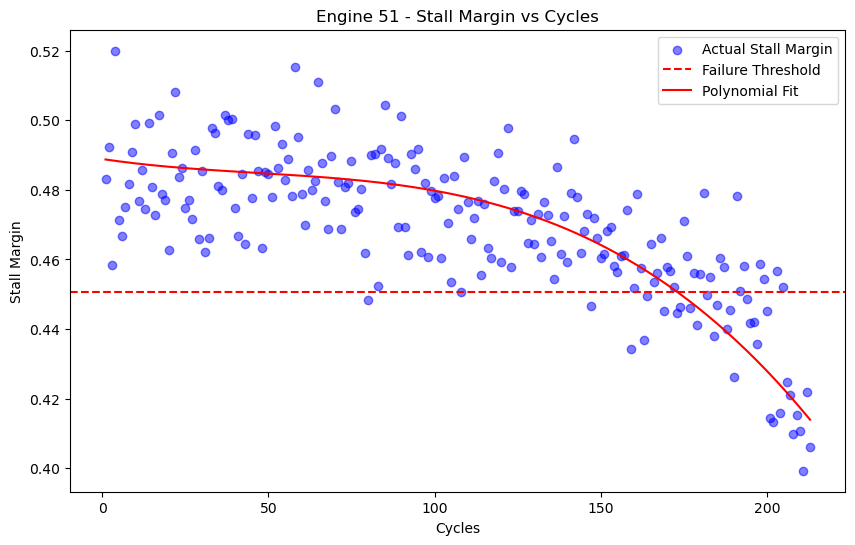

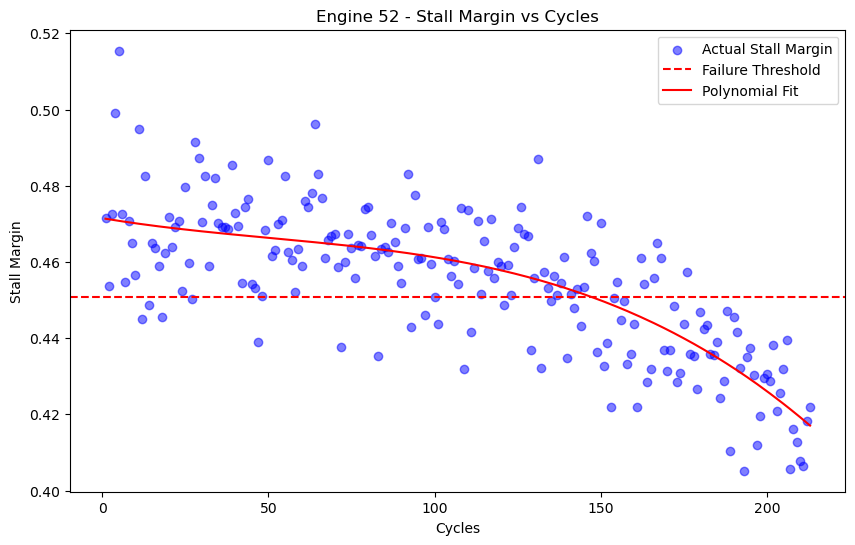

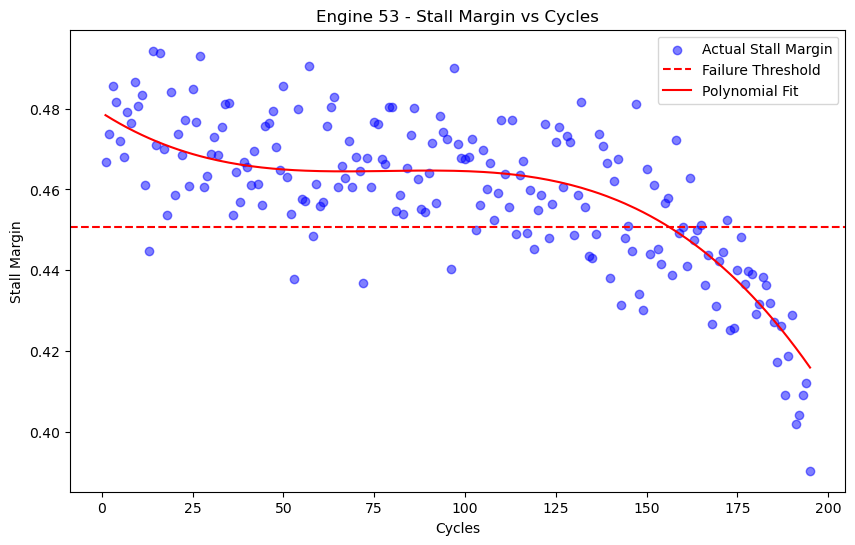

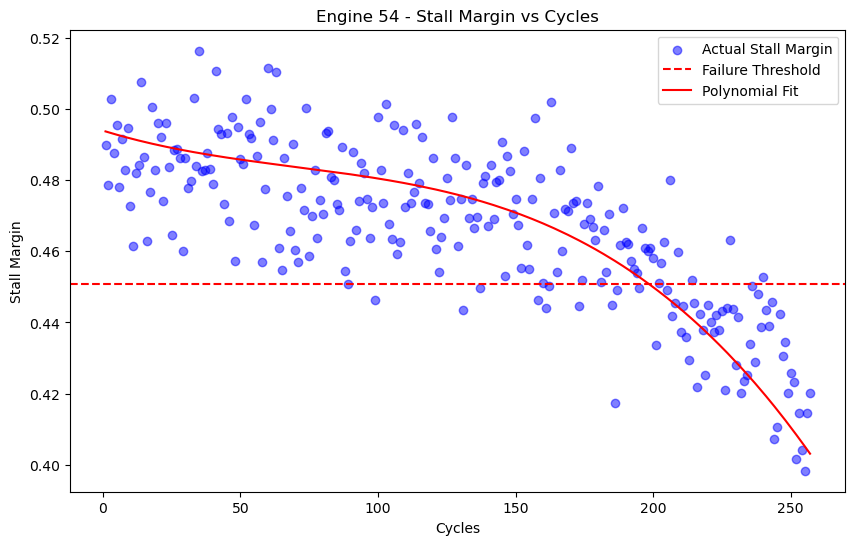

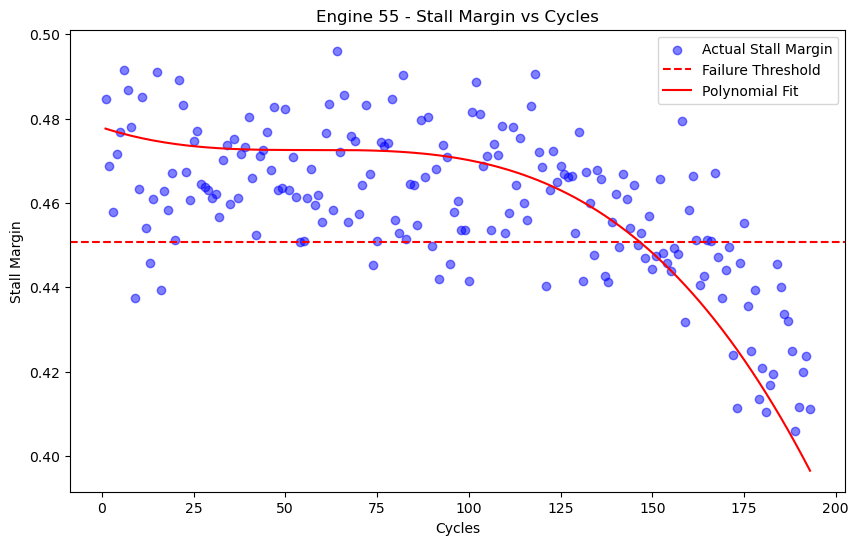

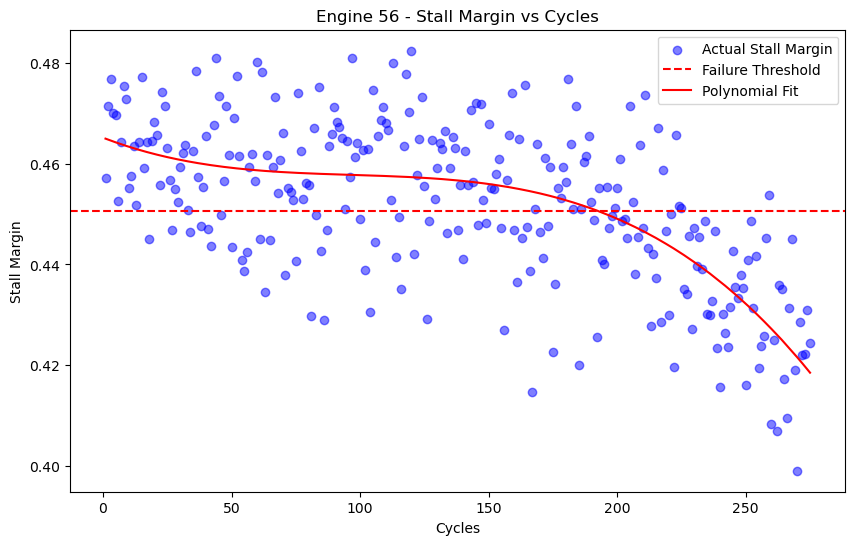

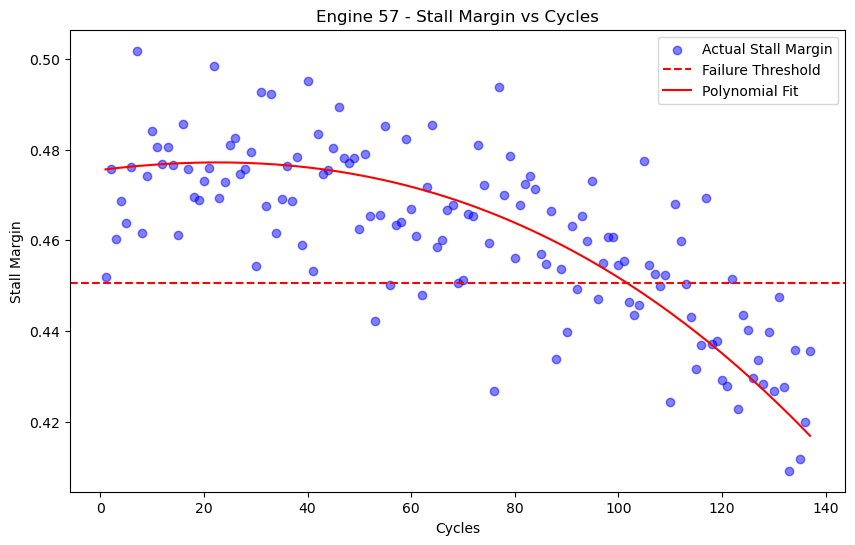

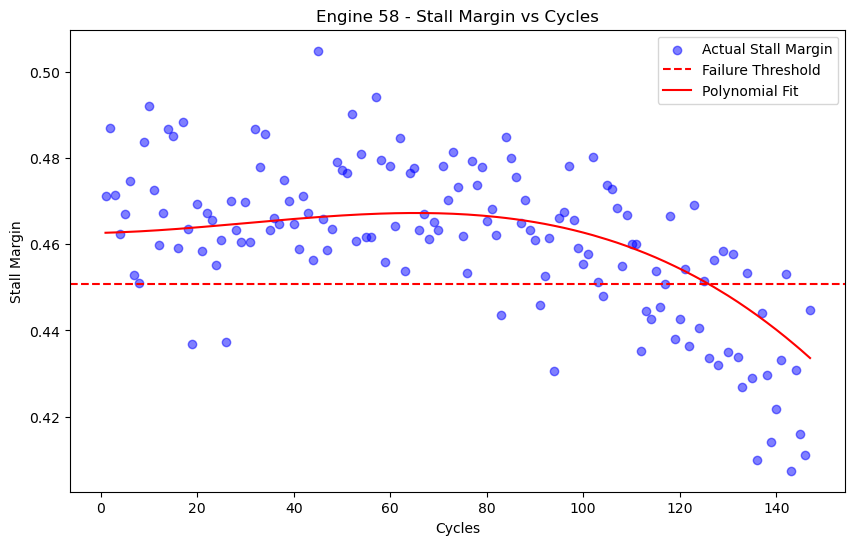

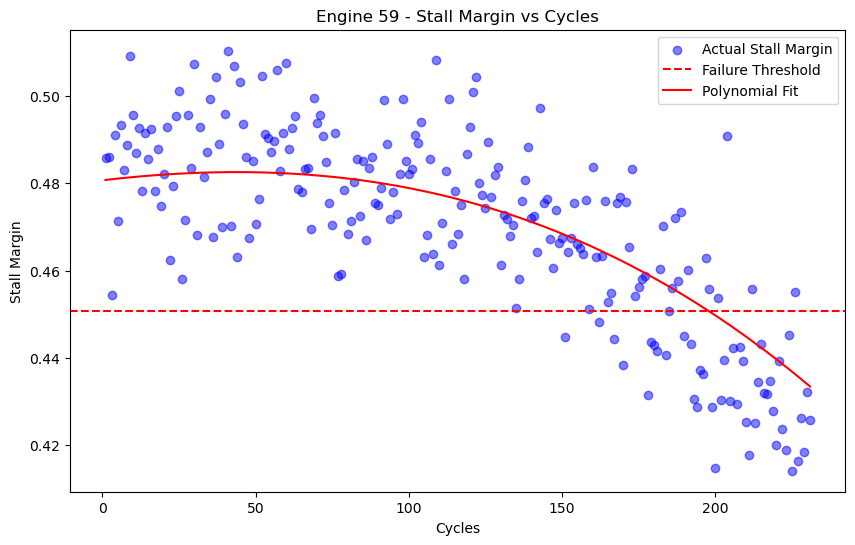

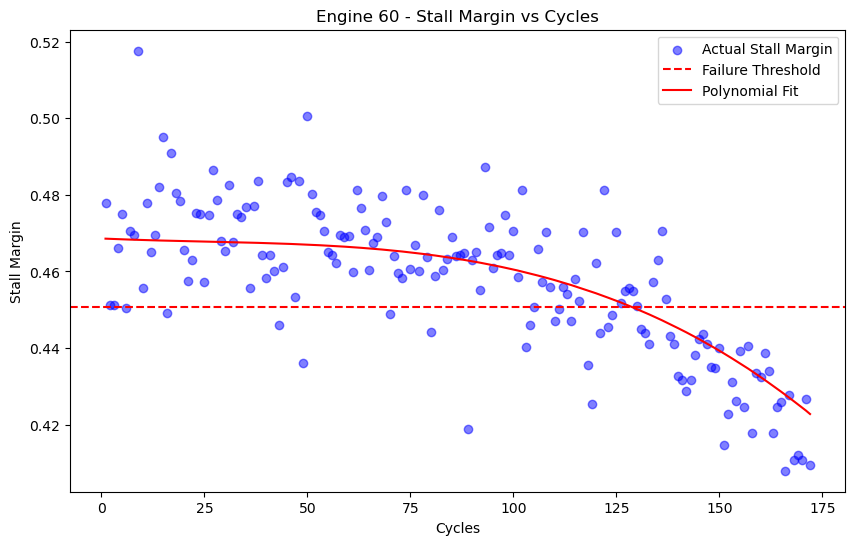

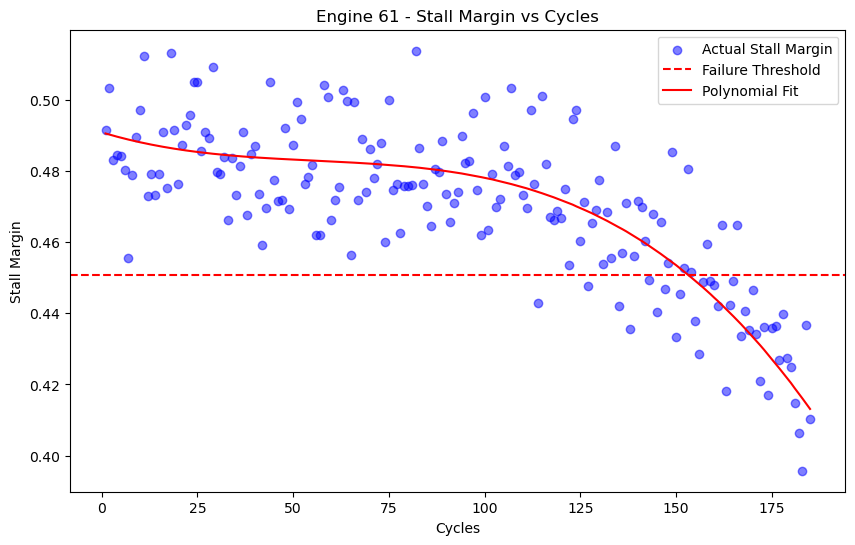

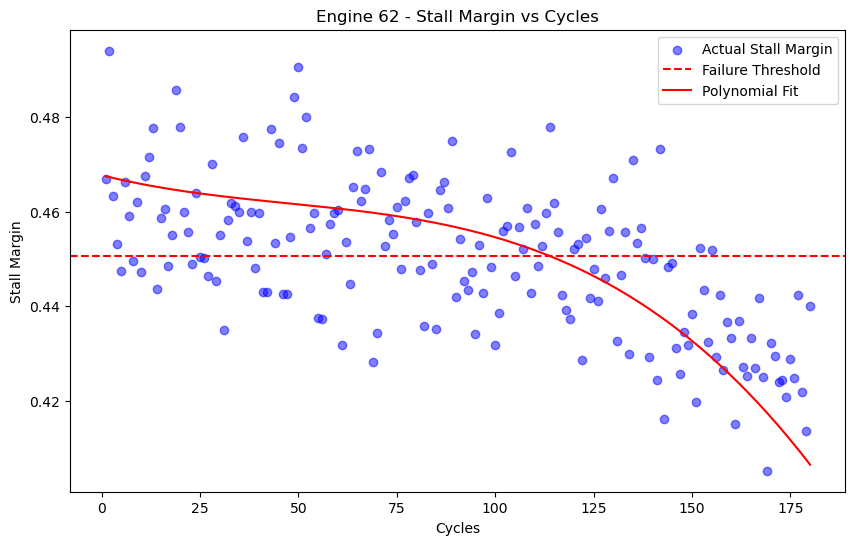

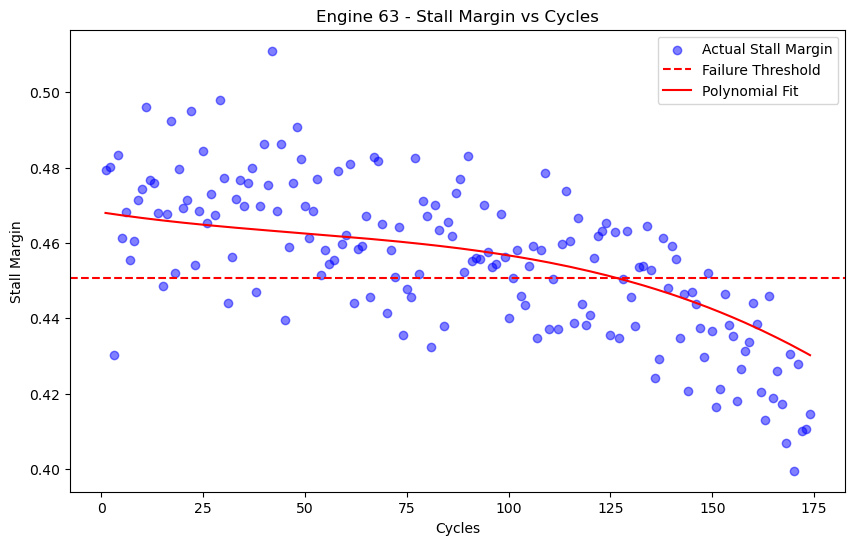

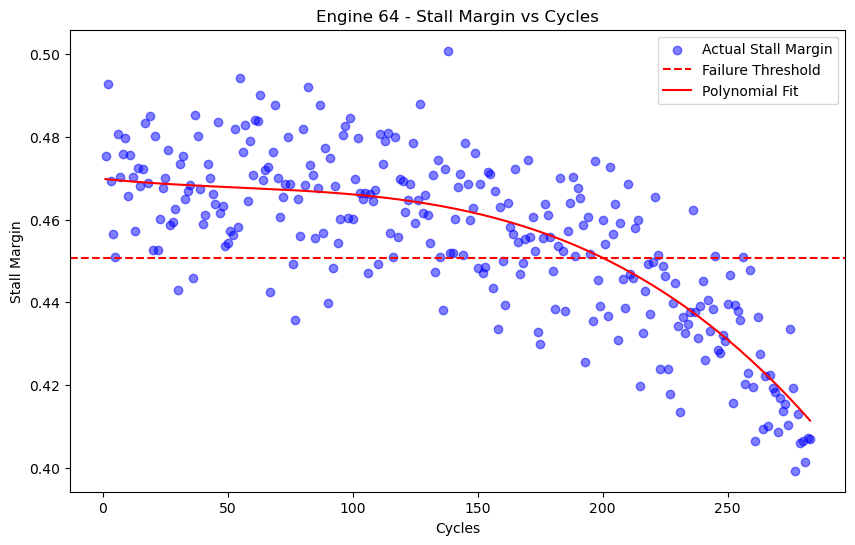

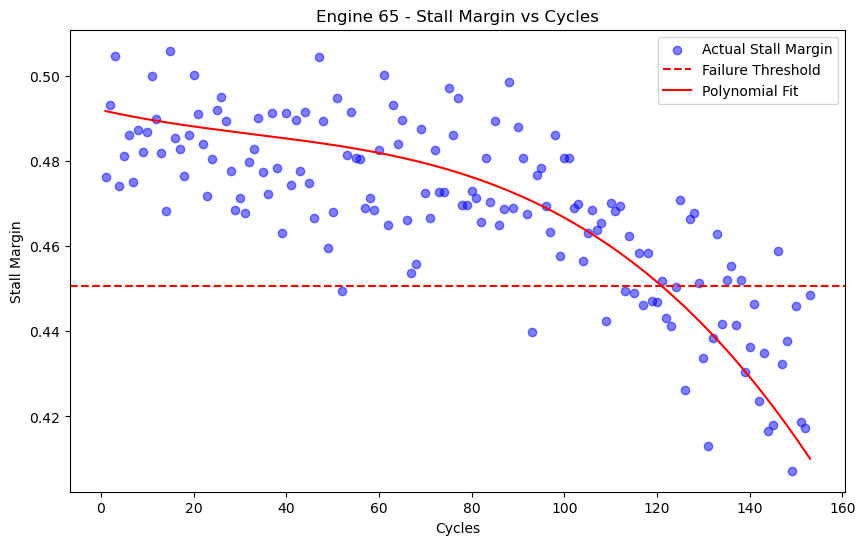

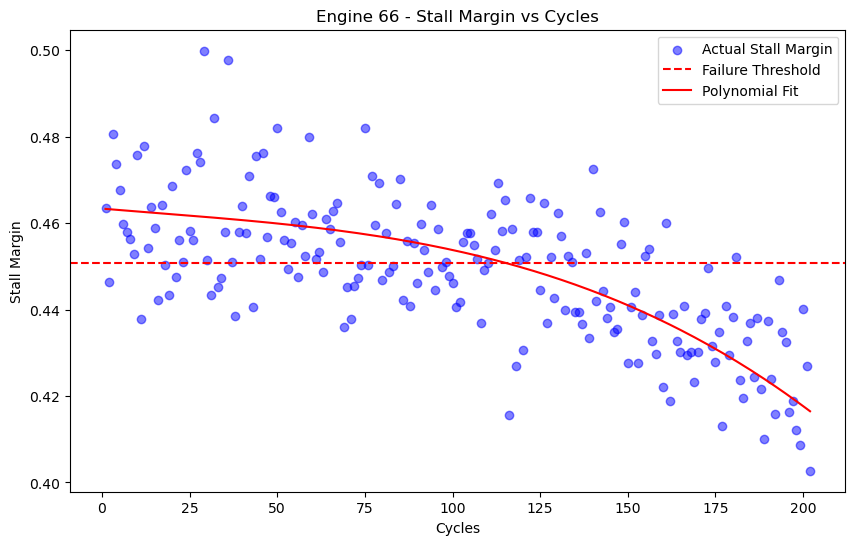

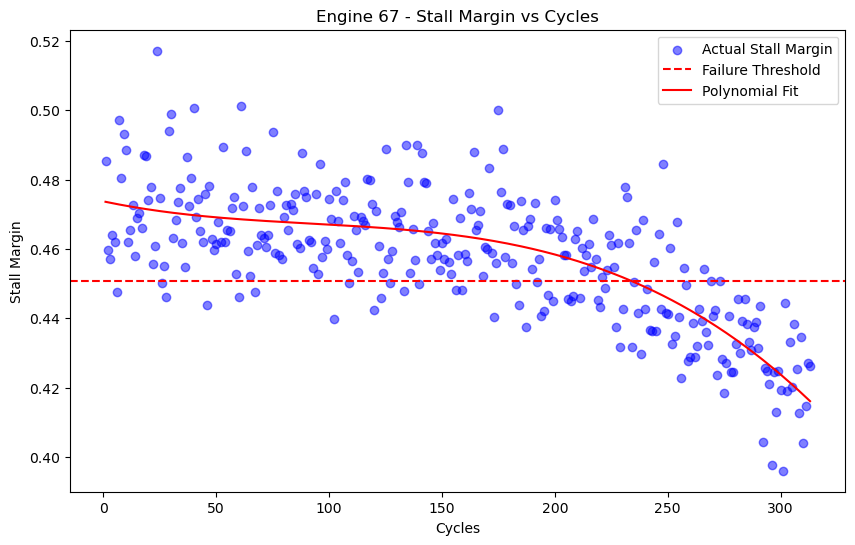

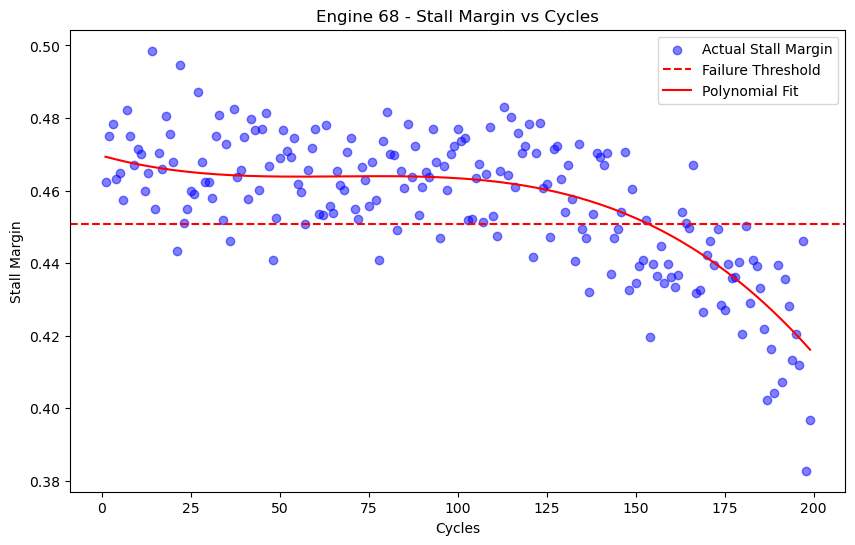

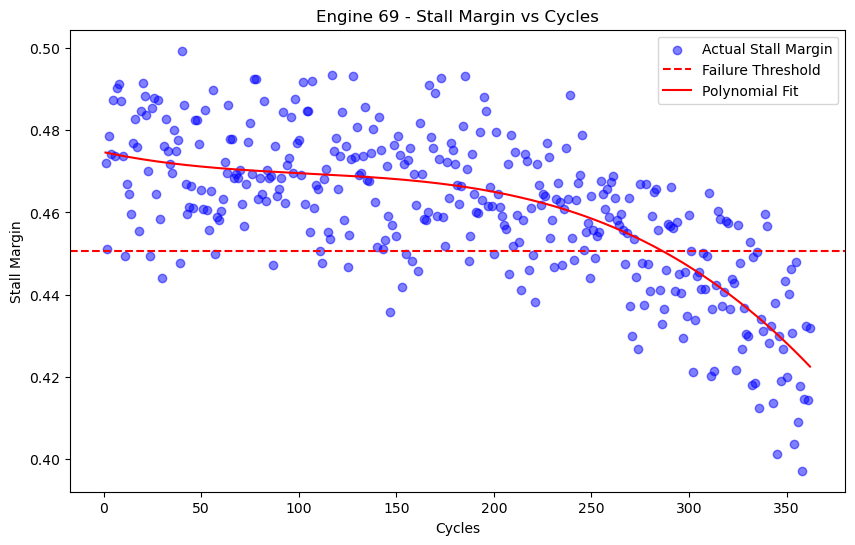

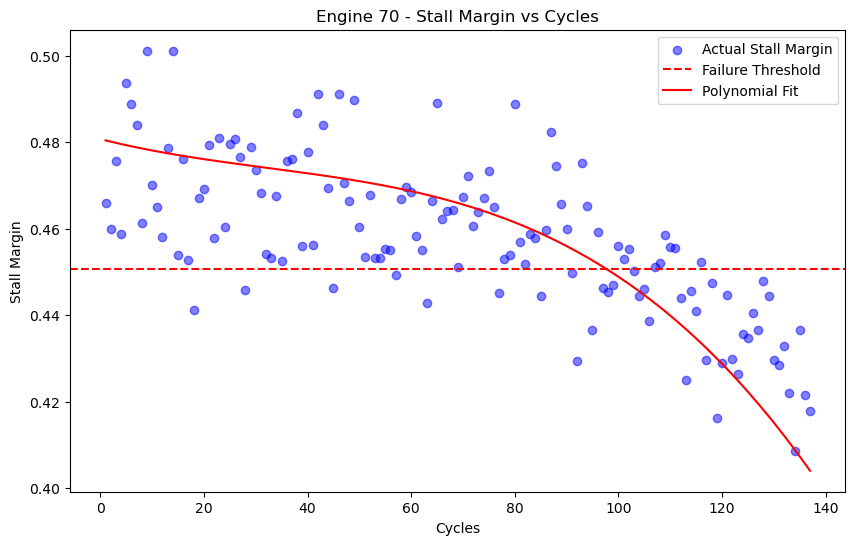

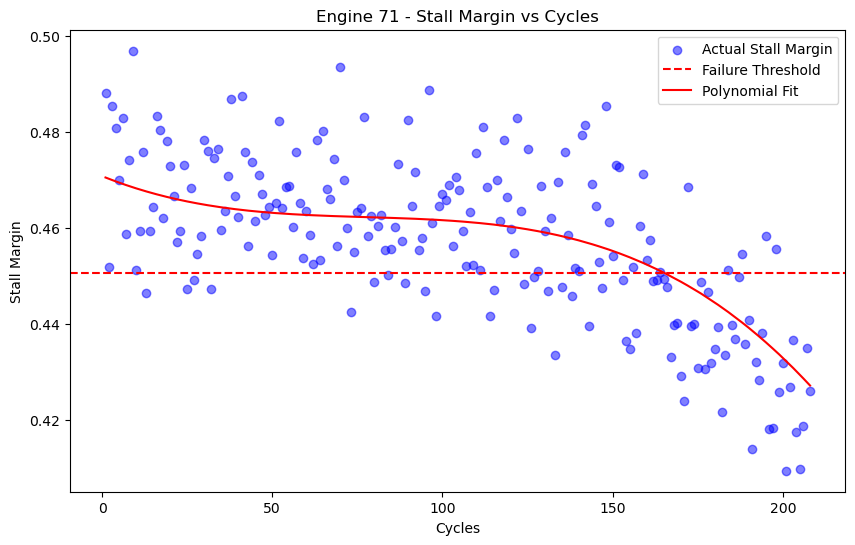

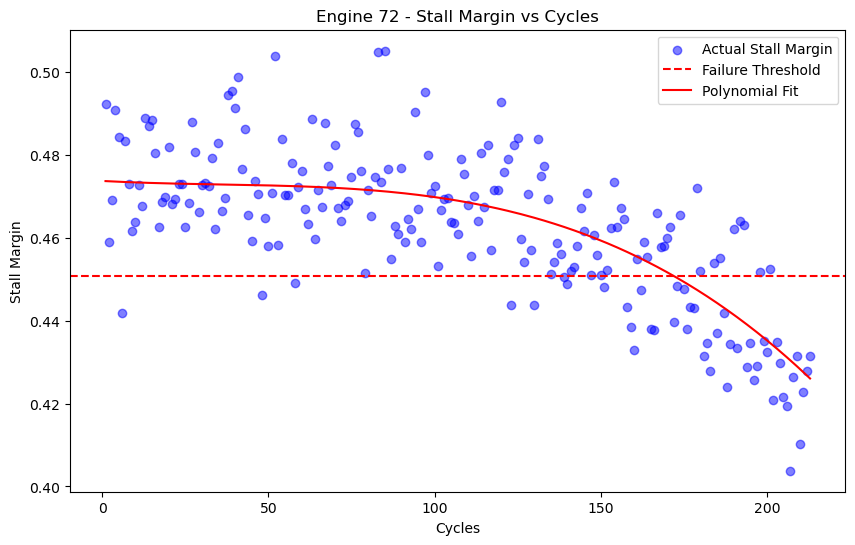

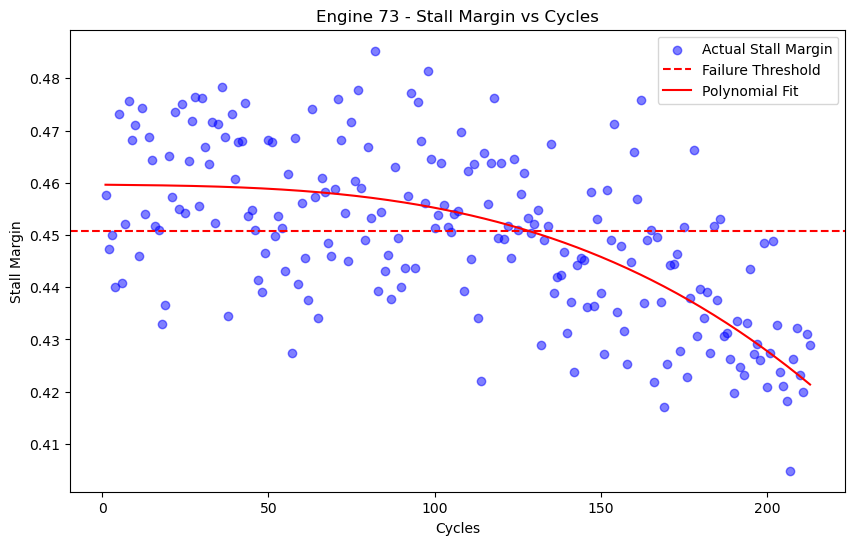

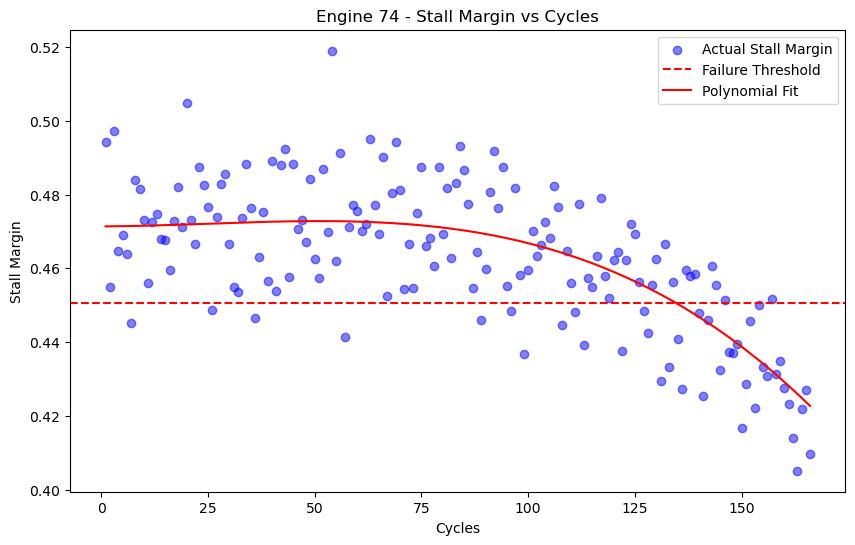

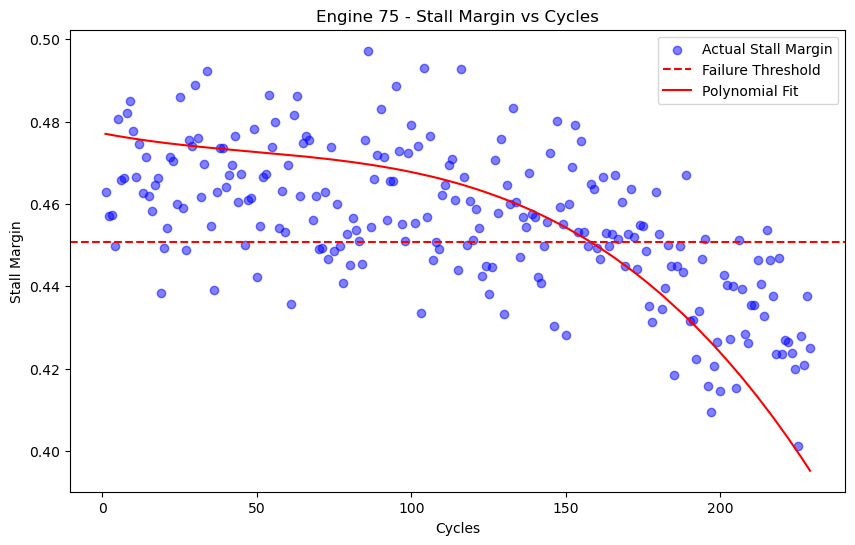

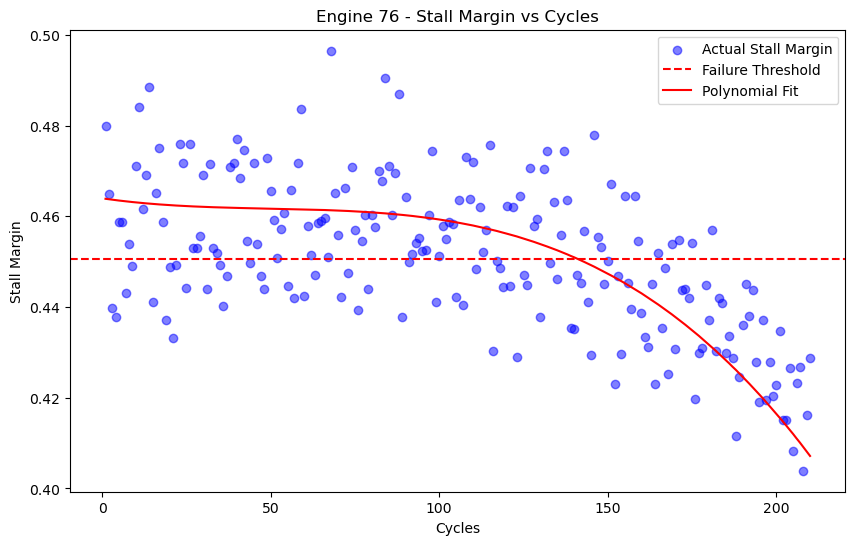

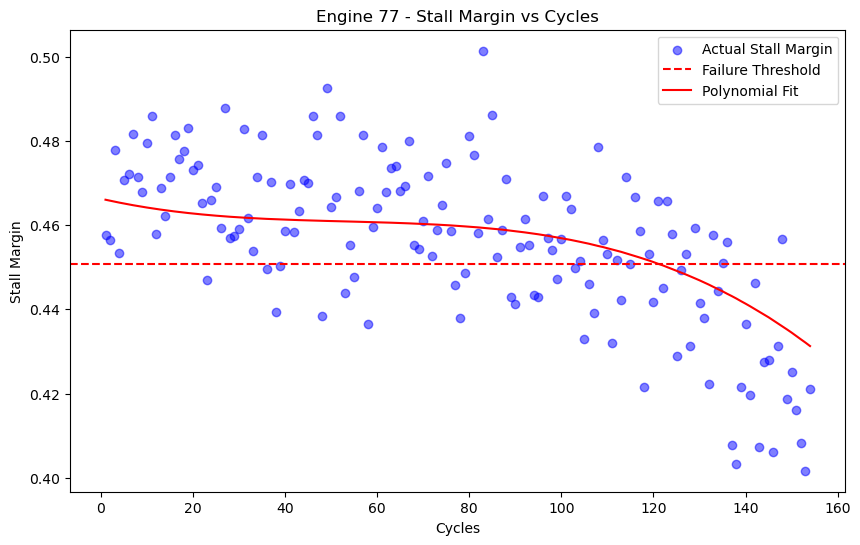

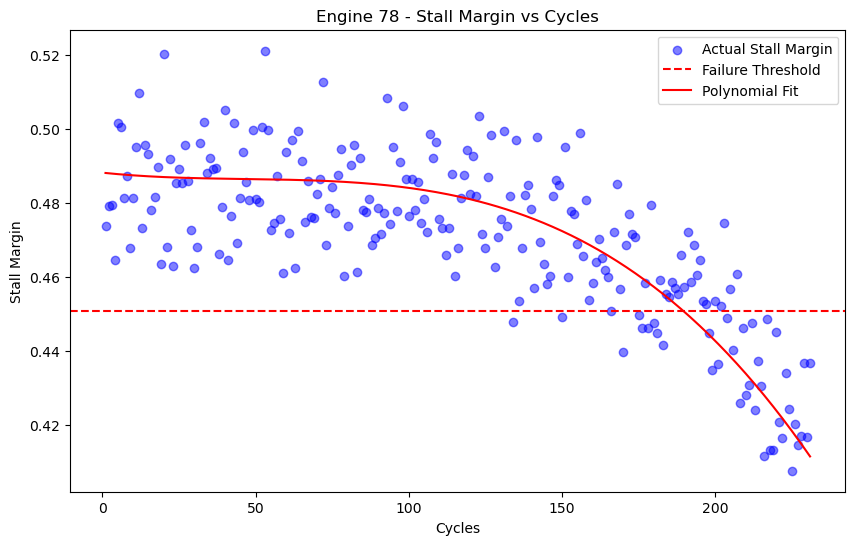

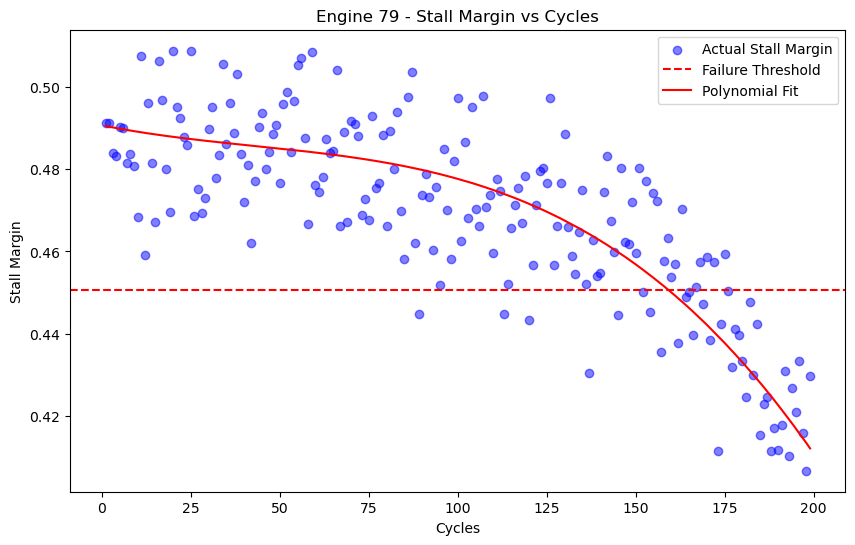

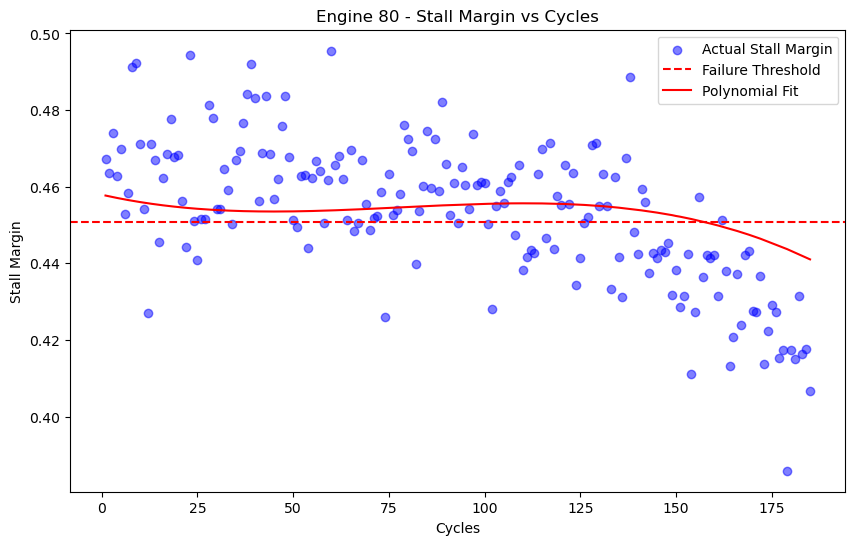

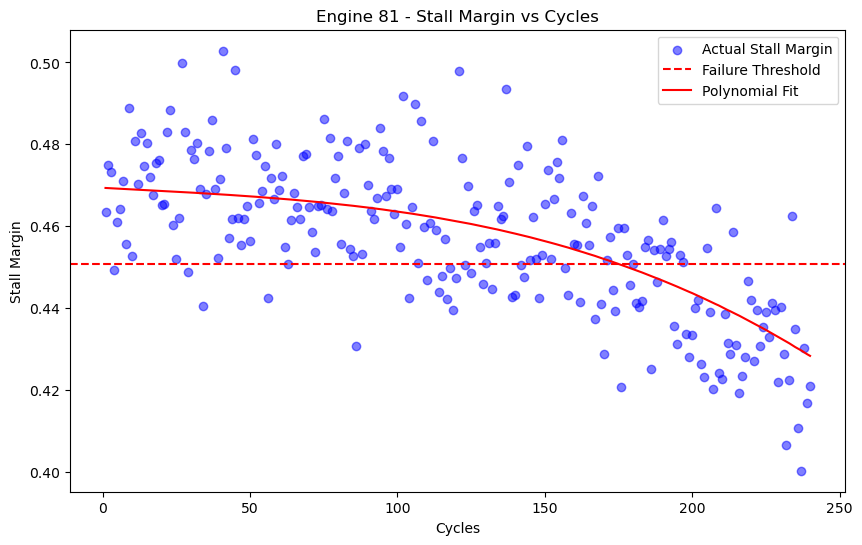

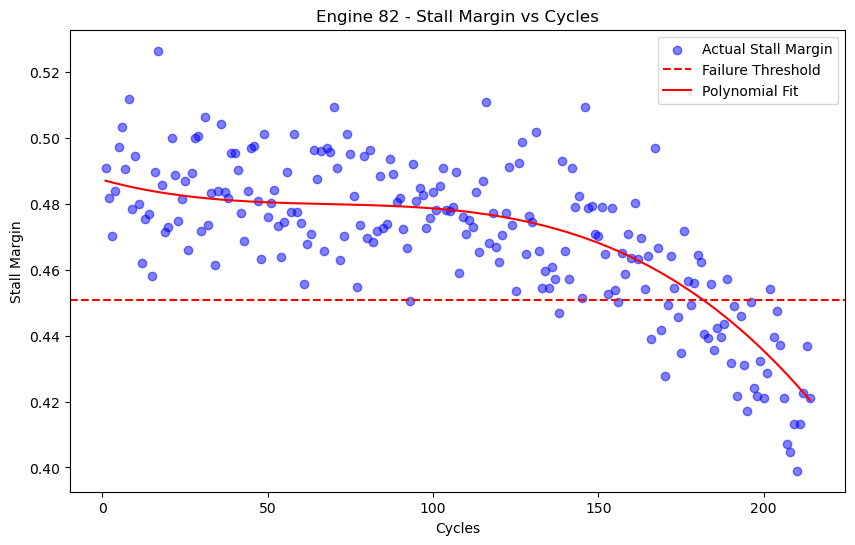

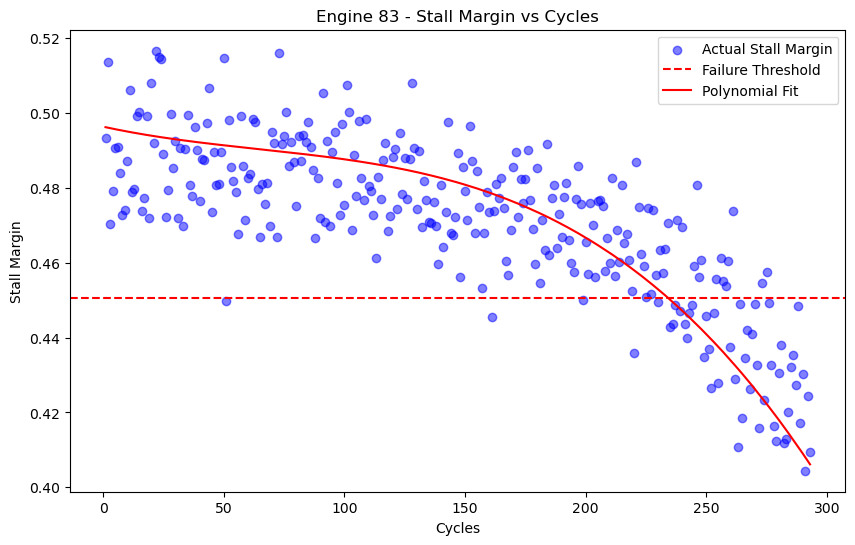

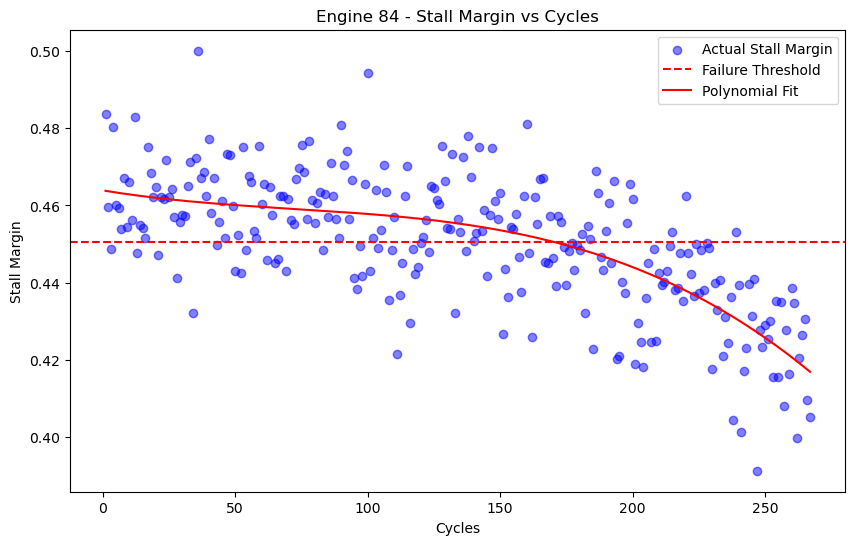

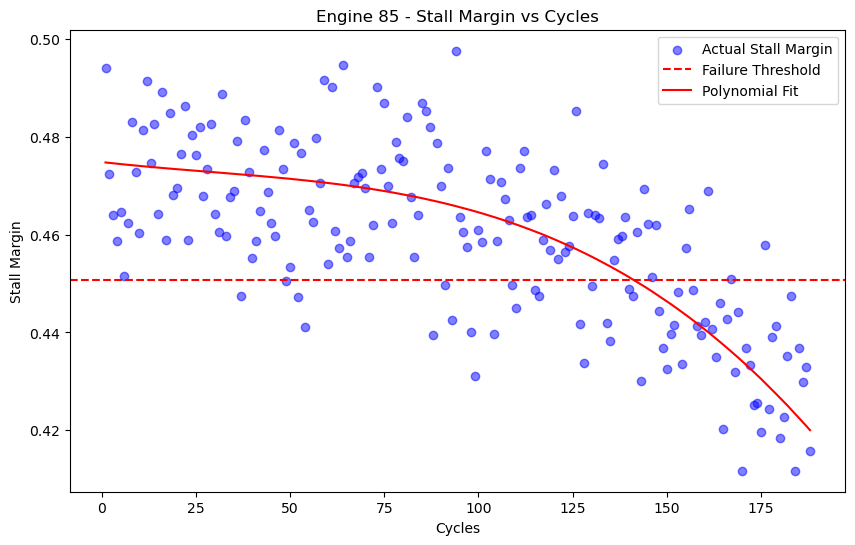

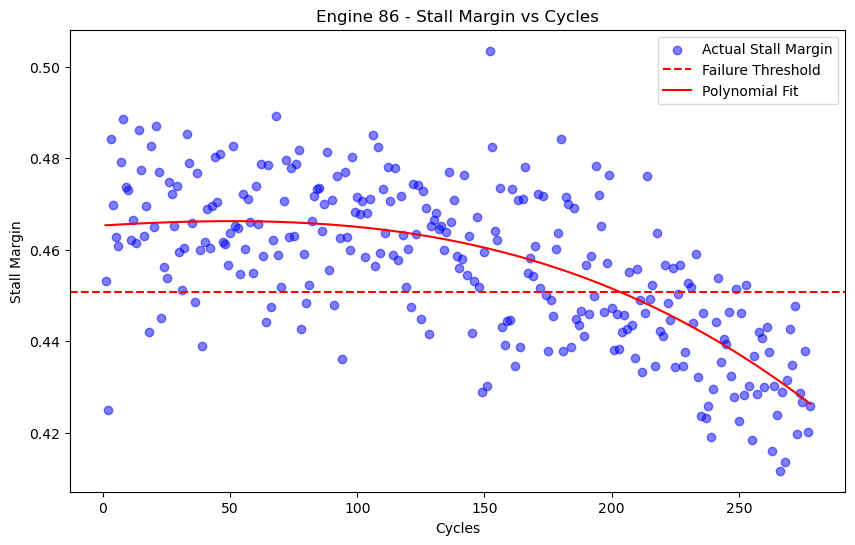

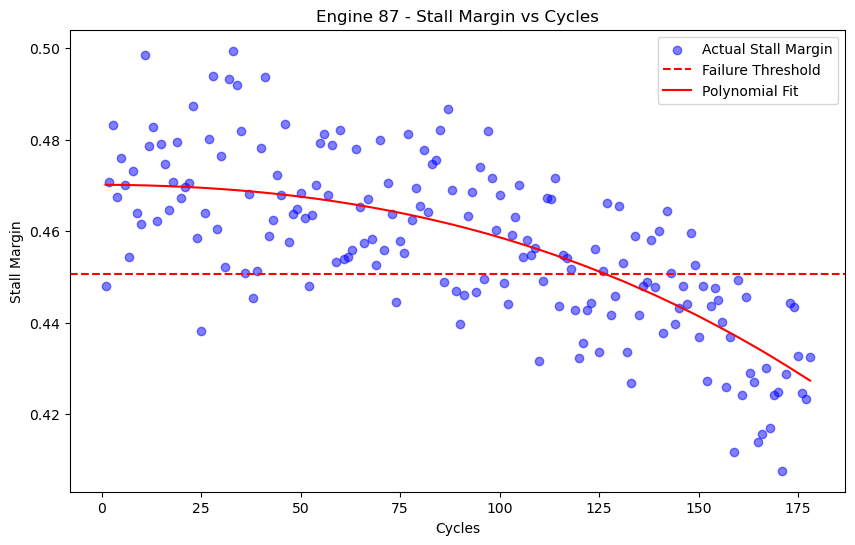

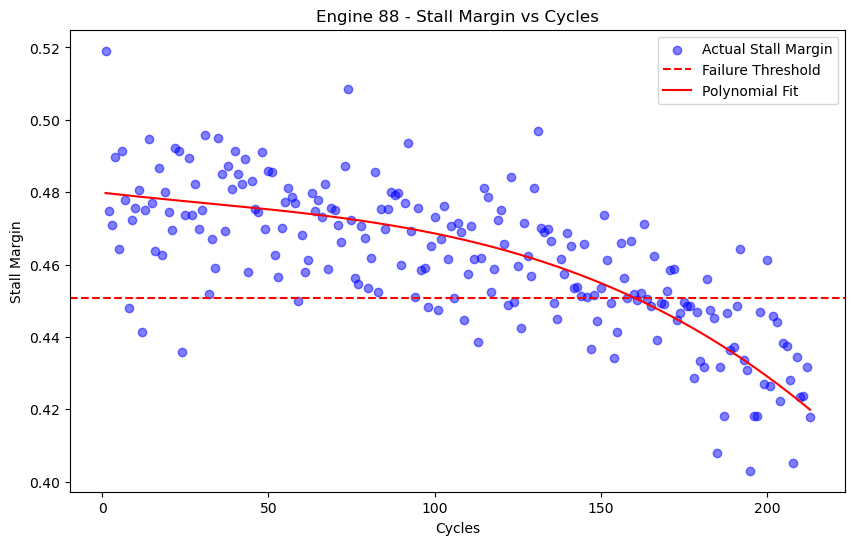

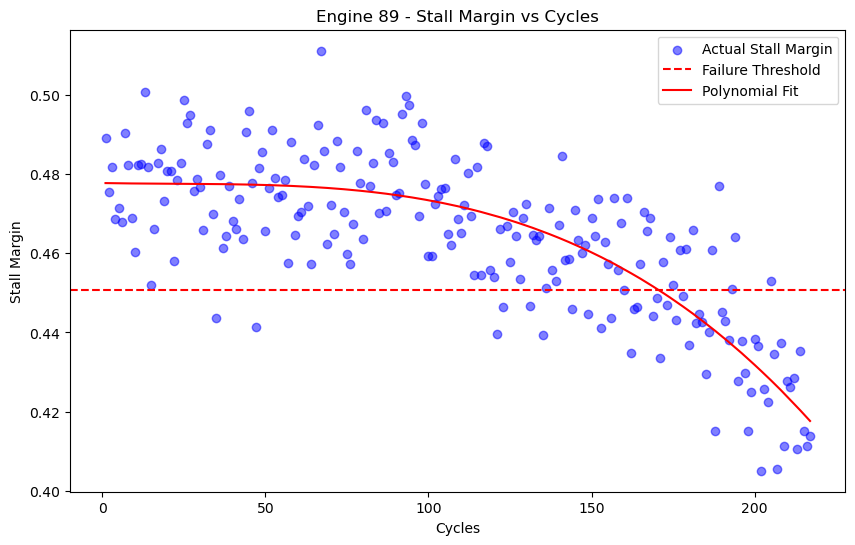

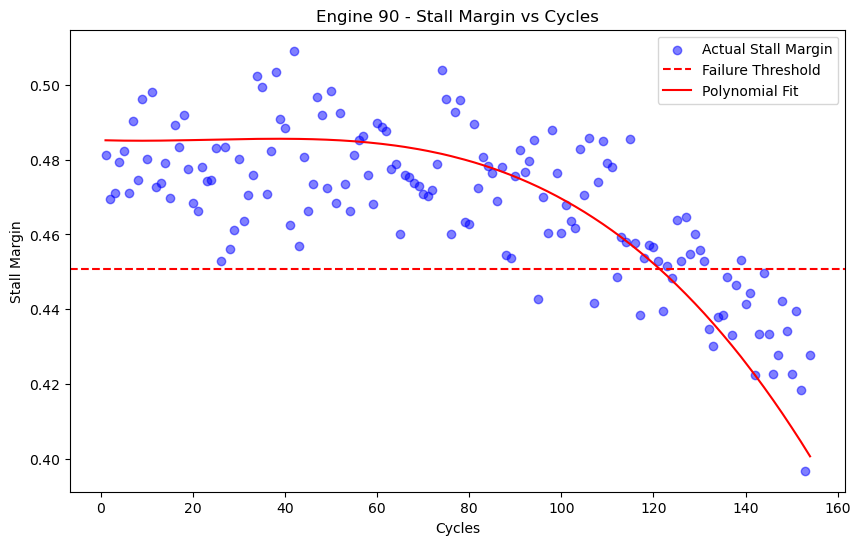

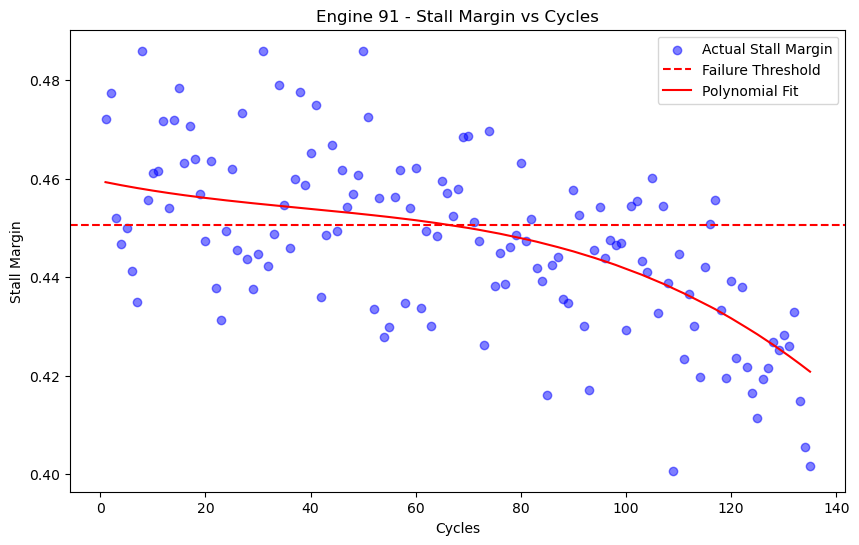

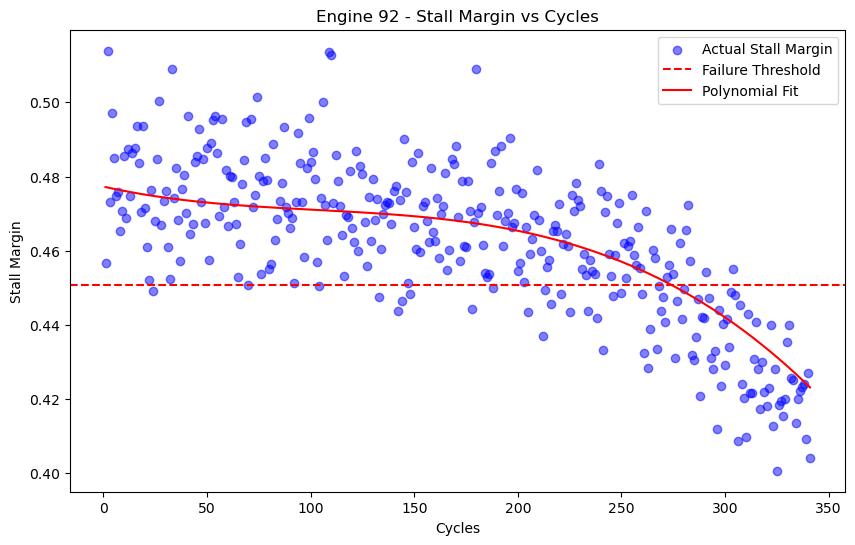

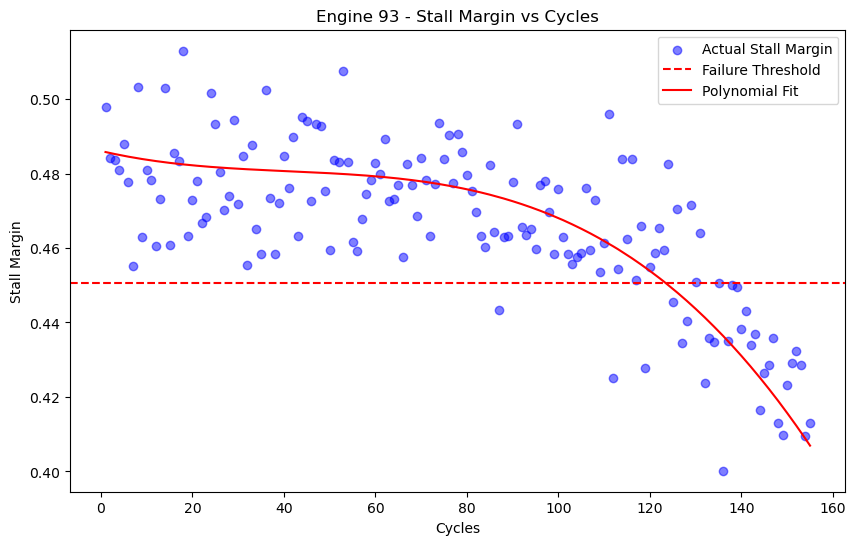

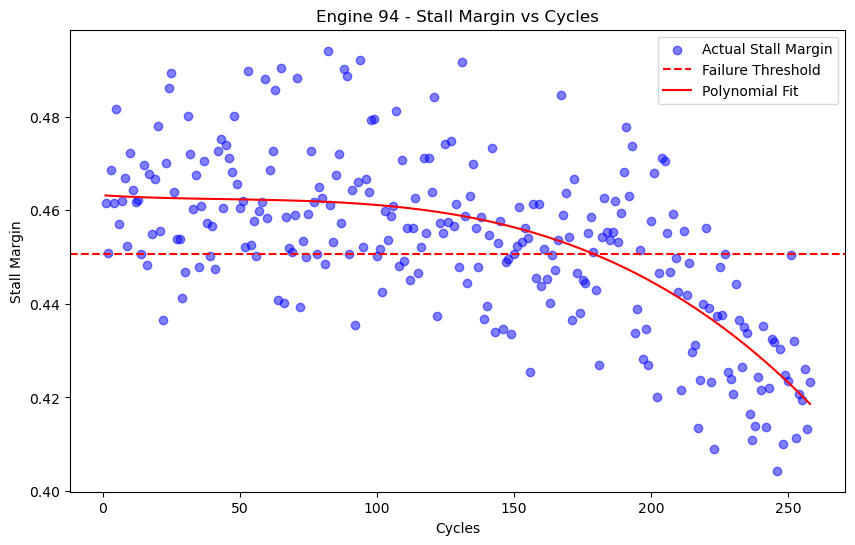

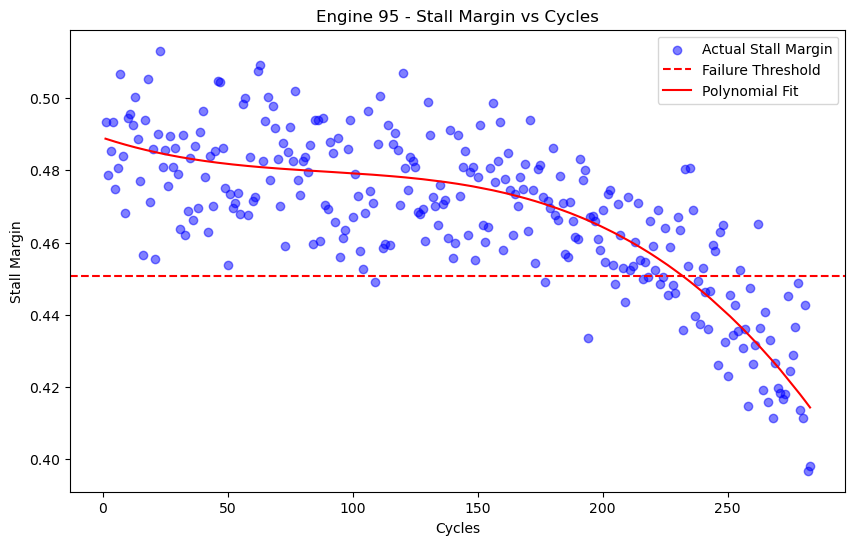

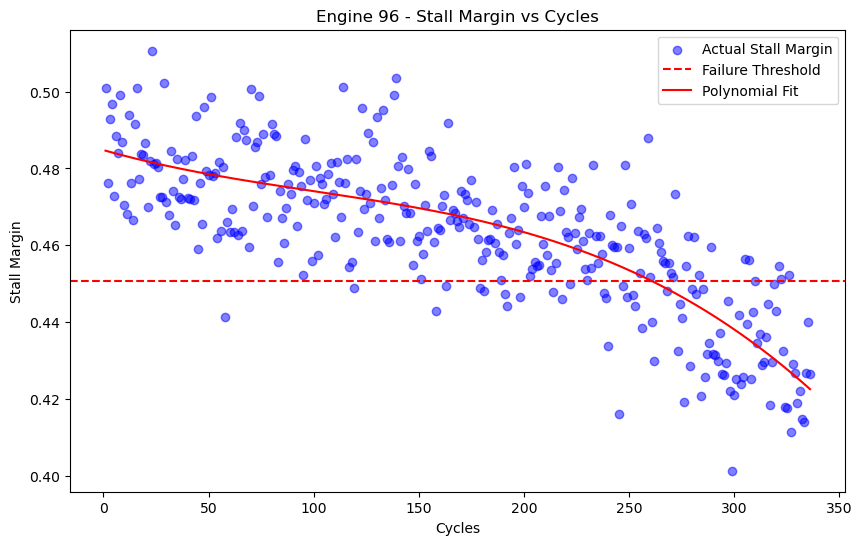

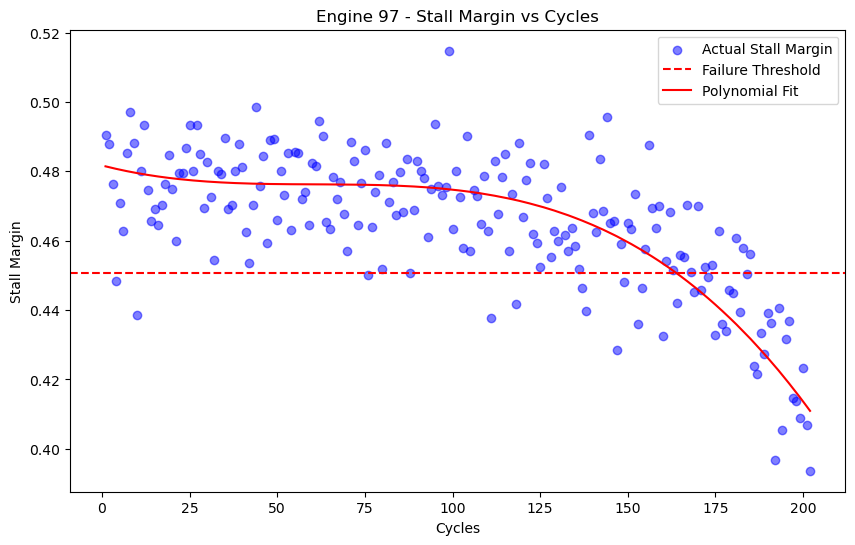

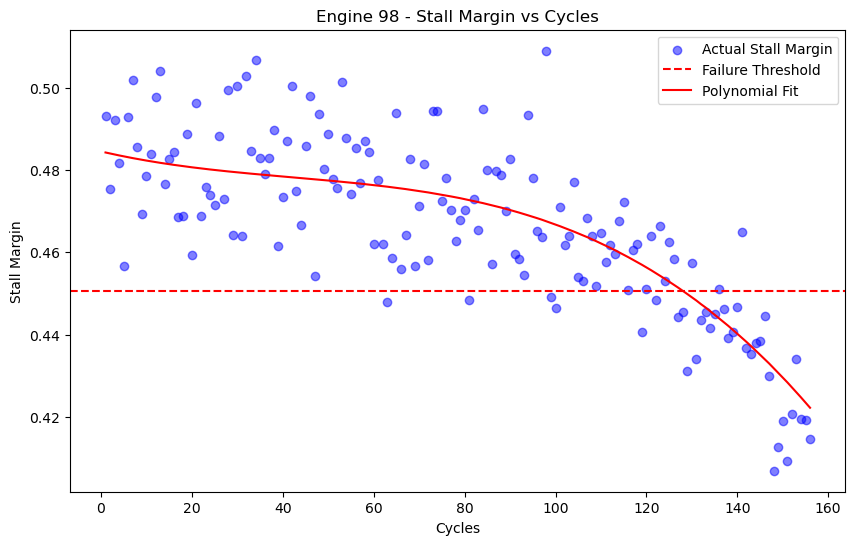

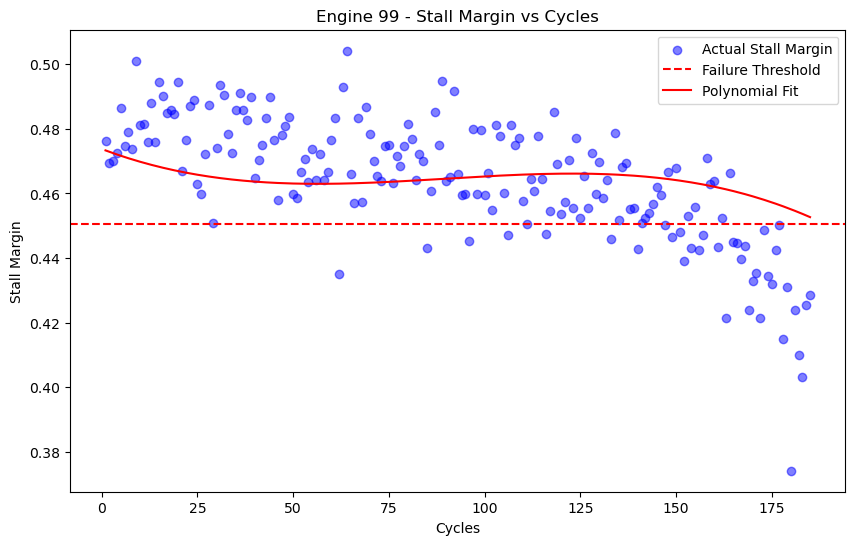

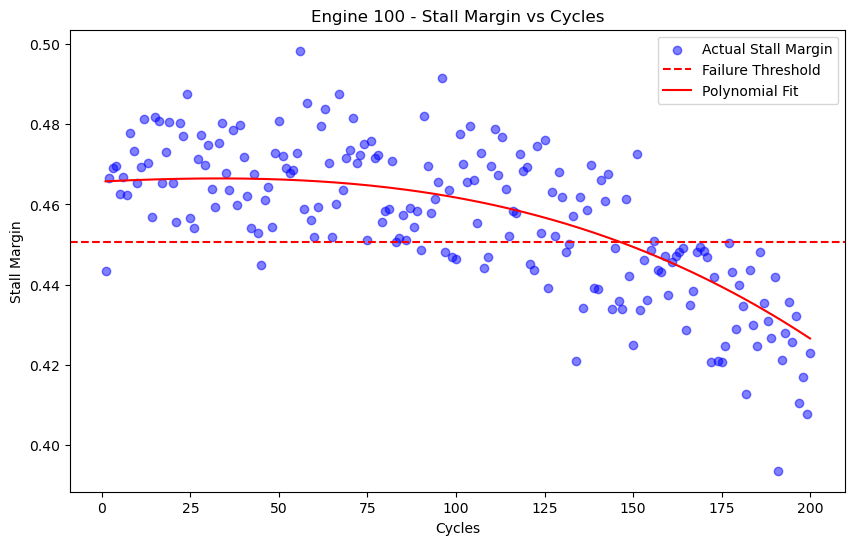

In [312]:
 #Get a list of unique engine numbers
unique_engines = FD001_data['Engine'].unique()

# Initialize a list to store results
engine_results = []

# Loop through each engine and fit a model
for engine in unique_engines:
    # Filter data for the current engine
    engine_data = FD001_data[FD001_data['Engine'] == engine]
    
    # Adding Features so that model can capture variance in the data effectively for HPC failure
    X = engine_data[['Cycles','Baseline_Efficiency','Initial_Wear_HPT_Efficiency','Initial_Wear_HPT_Flow','3000_Wear_HPT_Efficiency','3000_Wear_HPT_Flow','6000_Wear_HPT_Efficiency','6000_Wear_HPT_Flow']]
    y = engine_data['stall_margin']
    
    #Creating poly model
    poly = PolynomialFeatures(degree=3)
    X_poly = poly.fit_transform(X)
    model = LinearRegression(fit_intercept=True).fit(X_poly, y)
    
    # Store the model and data
    engine_results.append({
        'engine': engine,
        'model': model,
        'X_poly': X_poly,
        'y': y
    })
    
    # Predict the stall margin using the model
    y_pred = model.predict(X_poly)
    
    # Scatter plot for actual stall margin vs cycles
    plt.figure(figsize=(10, 6))
    plt.scatter(engine_data['Cycles'], y, color='blue', alpha=0.5, label='Actual Stall Margin')
    plt.axhline(stall_margin_failure_threshold, color='red', linestyle='--', label='Failure Threshold')
    plt.plot(engine_data['Cycles'], y_pred, color='red', label='Polynomial Fit')
    plt.title(f'Engine {engine} - Stall Margin vs Cycles')
    plt.xlabel('Cycles')
    plt.ylabel('Stall Margin')
    plt.legend()
    plt.show()


In [313]:
#Creating RUL based on observations above

In [314]:
print(poly_model.coef_)

[ 9.45584236e-08 -2.55919877e+03  1.11700933e+02  5.75513035e+01
 -7.07071723e+03 -3.61494537e+03 -9.31800899e+03  1.12509472e+04
  5.01186869e+03  0.00000000e+00  4.84248528e+00 -6.67317064e+00
 -8.12610041e+01 -9.66977594e+00  2.12349613e+02 -7.45031049e+01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -8.41341154e-02
  2.46535099e+00  5.04096195e+01  3.90028047e+01  6.73072924e+00
 -5.70340740e+01  3.51481338e-02 -6.95213480e+00 -9.12190936e-01
 -1.51529970e+01  1.56489455e+01  2.31253687e+02  1.86193226e+02
 -3.25625595e+02 -2.73480156e+02 -9.82686468e+01  3.24491999e+01
  2.45140244e+01 -5.11818821e+02  2.30403489e+02 -3.88823600e+02
  4.28365052e-09  0.00000000e+00 -1.03314252e+03 -2.98286991e+01
  3.79419599e+03 -2.78507167e+02 -1.68318404e+03 -5.63974299e+02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.55079913e+02
  3.73946010e+00 -2.62497

In [361]:
#FD001_data['RUL'] = (stall_margin - stall_margin_failure_threshold

max_engine_cycles = FD001_data.groupby("Engine")[['Cycles']].agg(max)
print(type(max_engine_cycles.info()))
print(max_engine_cycles)


#FD001_data['RUL-actual'] = FD001_data.groupby("Engine")[["Cycles"]].agg(max)

#print(FD001_data.head(20))

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 1 to 100
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Cycles  100 non-null    int64
dtypes: int64(1)
memory usage: 1.6 KB
<class 'NoneType'>
        Cycles
Engine        
1          192
2          287
3          179
4          189
5          269
6          188
7          259
8          150
9          201
10         222
11         240
12         170
13         163
14         180
15         207
16         209
17         276
18         195
19         158
20         234
21         195
22         202
23         168
24         147
25         230
26         199
27         156
28         165
29         163
30         194
31         234
32         191
33         200
34         195
35         181
36         158
37         170
38         194
39         128
40         188
41         216
42         196
43         207
44         192
45         158
46         256
47         214
48  

In [316]:
X = FD001_data
scale = StandardScaler()
X_scale = scale.fit_transform(X)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scale)


In [317]:
# Perform KMeans clustering
optimal_clusters = 3  # Based on the elbow method
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(X_pca)


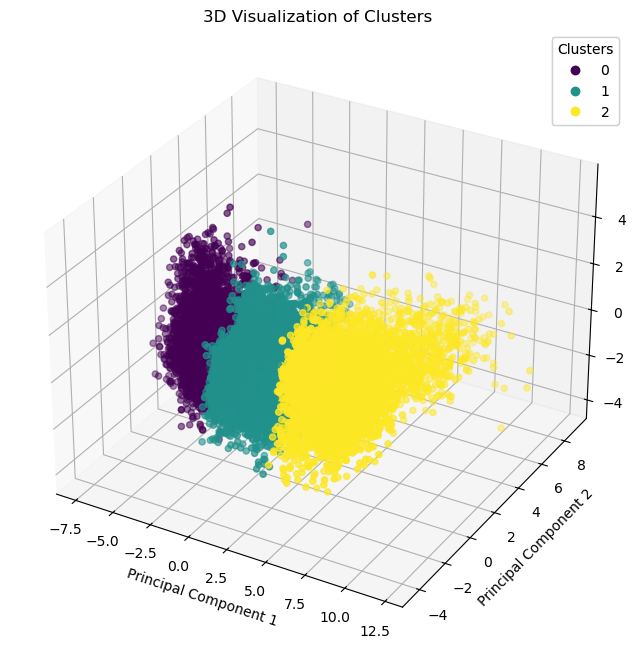

In [318]:
# 3D scatter plot of the clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=clusters, cmap='viridis', marker='o')

# Adding title and labels
ax.set_title('3D Visualization of Clusters')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Adding color bar to indicate cluster labels
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()